# Мастерская. Анализ активности в Slack

Гордейчук Сергей Тelegram: @Hawk_in

# Цель проекта - Проанализировать активность в чатах Слак

# Проблема - низкая обратная связь на важные посты, публикуемые в чатах

# Задачи:

- проанализировать поведение студентов в чатах;
- выявить паттерны, динамику, цикличность в течение дня, недели, месяца, года;
- визуализировать свои находки;
- помочь нам понять, когда активность в чатах наибольшая, и когда лучше публиковать посты/анонсы, чтобы получить больше откликов;
- проанализировать различные типы каналов, когорт, групп;
- оценить в каких общения больше, в каких меньше, и как они различаются от когорты к когорте, от канала к каналу.
- По возможности сделать дополнительные наблюдения.
- Сделать выводы, дать рекомендации. Результат оформляем в виде презентации в PDF.

### Шаг 1. Импортируем необходимые библиотеки и открываем базу данных


Импортируем необходимые библиотеки.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
import warnings
warnings.filterwarnings ('ignore')

Открываем файл с данными

In [2]:
try:
    df = pd.read_csv('C:/Users/gss03/Documents/Яндекс.Практикум/Мастерская/chat_data_clean.csv')
except:
    df = pd.read_csv('Documents/Яндекс.Практикум/Мастерская/chat_data_clean.csv')

Выведем основную информацию о датафрейме с помощью метода info()

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26533 entries, 0 to 26532
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     26533 non-null  int64  
 1   client_msg_id  18262 non-null  object 
 2   type           26533 non-null  object 
 3   user           23643 non-null  object 
 4   ts             26533 non-null  float64
 5   latest_reply   2303 non-null   float64
 6   team           15857 non-null  object 
 7   thread_ts      18222 non-null  float64
 8   subtype        8317 non-null   object 
 9   channel        26533 non-null  object 
 10  file_date      26533 non-null  object 
 11  attachments    26533 non-null  int64  
 12  reactions      4169 non-null   object 
 13  text_len       26533 non-null  int64  
 14  text_words     26533 non-null  int64  
dtypes: float64(3), int64(4), object(8)
memory usage: 3.0+ MB


Описание данных

- Unnamed: 0 - индекс (можно удалить)
- client_msg_id - id сообщения
- type - тип поста
- user - id пользователя
- ts - дата поста
- thread_ts - дата треда
- latest_reply - дата ответа
- team - факт вхождения в неизвестную группу (?)
- subtype - метка действий пользователя
- channel - канал
- file_date - дата файла
- attachments - прикреплённые файлы
- reactions - реакции
- text_len - длина текста сообщения
- text_words - количество слов в сообщении

Проверим датасет

In [4]:
df.head()

,Unnamed: 0,client_msg_id,type,user,ts,latest_reply,team,thread_ts,subtype,channel,file_date,attachments,reactions,text_len,text_words
0,0,ae31e785-257b-4290-a4c6-9721337f67ea,message,U03JYMWQLP5,1.669643e+09,1.669645e+09,TPV9DP0N4,1.669643e+09,NaN,data-analysts-bus,2022-11-28,0,NaN,297,47
1,1,7f644ae8-16d4-4c9e-9c4f-8b2d6df6a28d,message,U03V483FRKM,1.669645e+09,NaN,TPV9DP0N4,1.669643e+09,NaN,data-analysts-bus,2022-11-28,0,"[{'name': 'pray', 'users': ['U03JYMWQLP5'], 'c...",434,63
2,2,NaN,message,U02KVQJHQ5S,1.669647e+09,NaN,NaN,NaN,channel_join,data-analysts-bus,2022-11-28,0,NaN,37,5
3,3,6c5bf2c1-8579-413c-8e8f-ec3a0e3698a8,message,U03JYMWQLP5,1.669709e+09,1.669719e+09,NaN,1.669709e+09,NaN,data-analysts-bus,2022-11-29,0,"[{'name': 'cat-high-five', 'users': ['U040E2D6...",69,12
4,4,b5e3413b-8f04-4192-948b-2423eb3192b2,message,U040E2D6CF2,1.669711e+09,NaN,TPV9DP0N4,1.669709e+09,NaN,data-analysts-bus,2022-11-29,0,NaN,19,2


В датасете 14 колонок. Колонку Unnamed: 0 мы можем удалить

### Предобработка данных

Проверим на количество пропусков

In [5]:
df.isnull().sum().sort_values()

Unnamed: 0           0
type                 0
ts                   0
channel              0
file_date            0
attachments          0
text_len             0
text_words           0
user              2890
client_msg_id     8271
thread_ts         8311
team             10676
subtype          18216
reactions        22364
latest_reply     24230
dtype: int64

In [6]:
def pass_value_barh(df):
    try:
        (
            (df.isna().mean()*100)
            .to_frame()
            .rename(columns = {0:'space'})
            .query('space > 0')
            .sort_values(by = 'space', ascending = True)
            .plot(kind = 'barh', figsize = (19,6), legend = False, fontsize = 16)
            .set_title('Процент пропусков' + "\n", fontsize = 22, color = 'SteelBlue')    
        );    
    except:
        print('пропусков не осталось :) или произошла ошибка в первой части функции ')

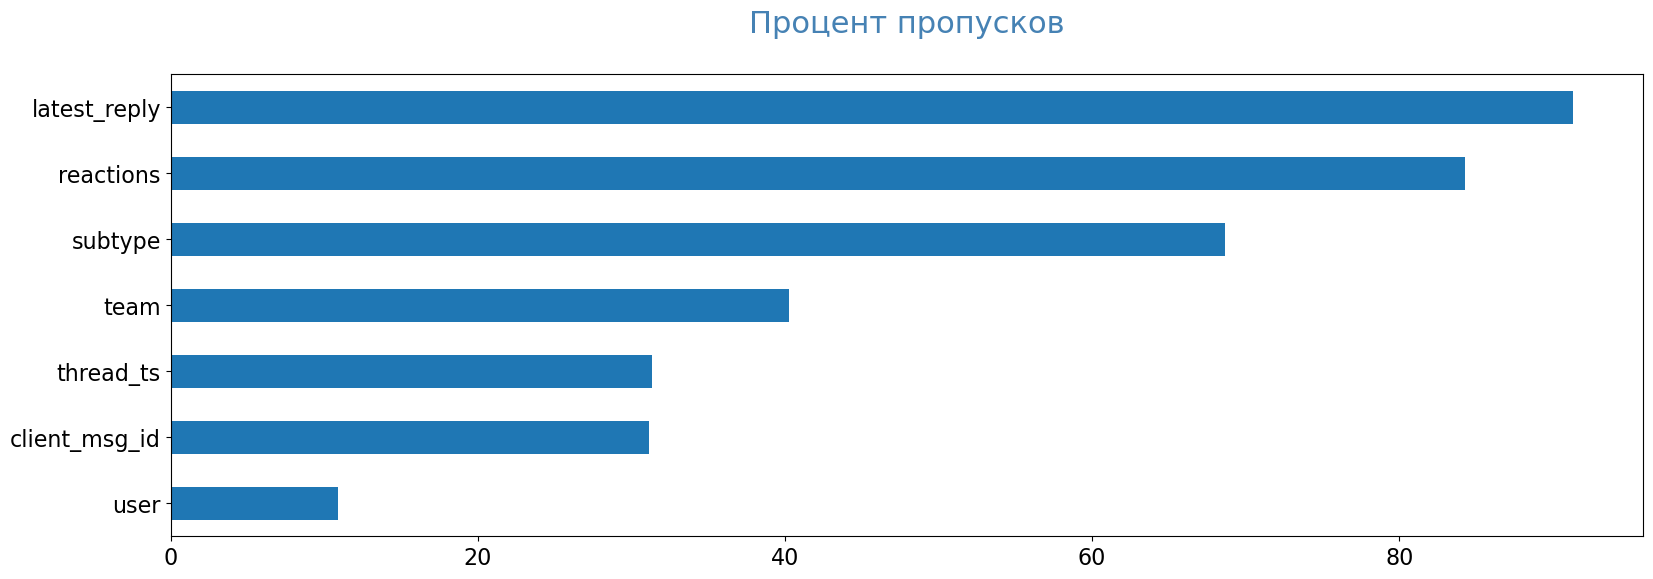

In [7]:
pass_value_barh(df)

Как мы видим в семи колонках есть у нас пропуски. Большее всего количество их в колонках latest_reply, reactions, subtype

Посмотрим на колонки

In [8]:
df.columns

Index(['Unnamed: 0', 'client_msg_id', 'type', 'user', 'ts', 'latest_reply',
       'team', 'thread_ts', 'subtype', 'channel', 'file_date', 'attachments',
       'reactions', 'text_len', 'text_words'],
      dtype='object')

Удалим Unnamed: 0

In [9]:
df.drop(['Unnamed: 0'] , axis=1 , inplace = True)

In [10]:
df.sample(5)

,client_msg_id,type,user,ts,latest_reply,team,thread_ts,subtype,channel,file_date,attachments,reactions,text_len,text_words
18248,6b2dfcf6-d7ab-42f6-a3d4-38eacc7e797c,message,U03NJECGW4V,1.670272e+09,NaN,TPV9DP0N4,1.669565e+09,NaN,ds_49_projects,2022-12-05,0,NaN,30,3
23991,NaN,message,NaN,1.669990e+09,NaN,NaN,NaN,bot_message,ds_bc_04_exerciser,2022-12-02,0,NaN,95,13
17585,204c512c-40c4-42df-a925-8bd3a14fc4f0,message,U039DEEFGTF,1.669661e+09,NaN,TPV9DP0N4,1.669619e+09,NaN,ds_48_exerciser,2022-11-28,0,NaN,113,13
16449,NaN,message,NaN,1.670168e+09,NaN,NaN,NaN,bot_message,ds_38_info,2022-12-04,0,NaN,621,30
6258,D7F9ADF0-99FA-4856-A028-1B011D2AC27E,message,U043ZT065BR,1.669725e+09,NaN,TPV9DP0N4,1.669619e+09,NaN,da_60_projects_01,2022-11-29,0,NaN,39,3


In [11]:
df.head(5)

,client_msg_id,type,user,ts,latest_reply,team,thread_ts,subtype,channel,file_date,attachments,reactions,text_len,text_words
0,ae31e785-257b-4290-a4c6-9721337f67ea,message,U03JYMWQLP5,1.669643e+09,1.669645e+09,TPV9DP0N4,1.669643e+09,NaN,data-analysts-bus,2022-11-28,0,NaN,297,47
1,7f644ae8-16d4-4c9e-9c4f-8b2d6df6a28d,message,U03V483FRKM,1.669645e+09,NaN,TPV9DP0N4,1.669643e+09,NaN,data-analysts-bus,2022-11-28,0,"[{'name': 'pray', 'users': ['U03JYMWQLP5'], 'c...",434,63
2,NaN,message,U02KVQJHQ5S,1.669647e+09,NaN,NaN,NaN,channel_join,data-analysts-bus,2022-11-28,0,NaN,37,5
3,6c5bf2c1-8579-413c-8e8f-ec3a0e3698a8,message,U03JYMWQLP5,1.669709e+09,1.669719e+09,NaN,1.669709e+09,NaN,data-analysts-bus,2022-11-29,0,"[{'name': 'cat-high-five', 'users': ['U040E2D6...",69,12
4,b5e3413b-8f04-4192-948b-2423eb3192b2,message,U040E2D6CF2,1.669711e+09,NaN,TPV9DP0N4,1.669709e+09,NaN,data-analysts-bus,2022-11-29,0,NaN,19,2


Переименуем некоторые колонки

In [12]:
df.rename(columns = {'user':'user_id', 'ts':'date_post', 'thread_ts': 'date_threads', }, inplace = True )

In [13]:
df.head(5)

,client_msg_id,type,user_id,date_post,latest_reply,team,date_threads,subtype,channel,file_date,attachments,reactions,text_len,text_words
0,ae31e785-257b-4290-a4c6-9721337f67ea,message,U03JYMWQLP5,1.669643e+09,1.669645e+09,TPV9DP0N4,1.669643e+09,NaN,data-analysts-bus,2022-11-28,0,NaN,297,47
1,7f644ae8-16d4-4c9e-9c4f-8b2d6df6a28d,message,U03V483FRKM,1.669645e+09,NaN,TPV9DP0N4,1.669643e+09,NaN,data-analysts-bus,2022-11-28,0,"[{'name': 'pray', 'users': ['U03JYMWQLP5'], 'c...",434,63
2,NaN,message,U02KVQJHQ5S,1.669647e+09,NaN,NaN,NaN,channel_join,data-analysts-bus,2022-11-28,0,NaN,37,5
3,6c5bf2c1-8579-413c-8e8f-ec3a0e3698a8,message,U03JYMWQLP5,1.669709e+09,1.669719e+09,NaN,1.669709e+09,NaN,data-analysts-bus,2022-11-29,0,"[{'name': 'cat-high-five', 'users': ['U040E2D6...",69,12
4,b5e3413b-8f04-4192-948b-2423eb3192b2,message,U040E2D6CF2,1.669711e+09,NaN,TPV9DP0N4,1.669709e+09,NaN,data-analysts-bus,2022-11-29,0,NaN,19,2


Поправим формат дат

In [14]:
def to_date(column): # для упрощения создадим функцию.
    df[column] = pd.to_datetime(df[column], unit='s').astype('datetime64[s]').dt.round('1s') # так же поменяем тип даты с object на datetime64

In [15]:
to_date('date_post')
to_date('latest_reply')
to_date('date_threads')
display(df.head())

,client_msg_id,type,user_id,date_post,latest_reply,team,date_threads,subtype,channel,file_date,attachments,reactions,text_len,text_words
0,ae31e785-257b-4290-a4c6-9721337f67ea,message,U03JYMWQLP5,2022-11-28 13:49:23,2022-11-28 14:24:08,TPV9DP0N4,2022-11-28 13:49:23,NaN,data-analysts-bus,2022-11-28,0,NaN,297,47
1,7f644ae8-16d4-4c9e-9c4f-8b2d6df6a28d,message,U03V483FRKM,2022-11-28 14:24:08,NaT,TPV9DP0N4,2022-11-28 13:49:23,NaN,data-analysts-bus,2022-11-28,0,"[{'name': 'pray', 'users': ['U03JYMWQLP5'], 'c...",434,63
2,NaN,message,U02KVQJHQ5S,2022-11-28 14:48:50,NaT,NaN,NaT,channel_join,data-analysts-bus,2022-11-28,0,NaN,37,5
3,6c5bf2c1-8579-413c-8e8f-ec3a0e3698a8,message,U03JYMWQLP5,2022-11-29 08:08:12,2022-11-29 10:56:57,NaN,2022-11-29 08:08:12,NaN,data-analysts-bus,2022-11-29,0,"[{'name': 'cat-high-five', 'users': ['U040E2D6...",69,12
4,b5e3413b-8f04-4192-948b-2423eb3192b2,message,U040E2D6CF2,2022-11-29 08:32:32,NaT,TPV9DP0N4,2022-11-29 08:08:12,NaN,data-analysts-bus,2022-11-29,0,NaN,19,2


In [16]:
df['file_date']=df['file_date'].astype('datetime64[s]')

In [17]:
df.head(5)

,client_msg_id,type,user_id,date_post,latest_reply,team,date_threads,subtype,channel,file_date,attachments,reactions,text_len,text_words
0,ae31e785-257b-4290-a4c6-9721337f67ea,message,U03JYMWQLP5,2022-11-28 13:49:23,2022-11-28 14:24:08,TPV9DP0N4,2022-11-28 13:49:23,NaN,data-analysts-bus,2022-11-28,0,NaN,297,47
1,7f644ae8-16d4-4c9e-9c4f-8b2d6df6a28d,message,U03V483FRKM,2022-11-28 14:24:08,NaT,TPV9DP0N4,2022-11-28 13:49:23,NaN,data-analysts-bus,2022-11-28,0,"[{'name': 'pray', 'users': ['U03JYMWQLP5'], 'c...",434,63
2,NaN,message,U02KVQJHQ5S,2022-11-28 14:48:50,NaT,NaN,NaT,channel_join,data-analysts-bus,2022-11-28,0,NaN,37,5
3,6c5bf2c1-8579-413c-8e8f-ec3a0e3698a8,message,U03JYMWQLP5,2022-11-29 08:08:12,2022-11-29 10:56:57,NaN,2022-11-29 08:08:12,NaN,data-analysts-bus,2022-11-29,0,"[{'name': 'cat-high-five', 'users': ['U040E2D6...",69,12
4,b5e3413b-8f04-4192-948b-2423eb3192b2,message,U040E2D6CF2,2022-11-29 08:32:32,NaT,TPV9DP0N4,2022-11-29 08:08:12,NaN,data-analysts-bus,2022-11-29,0,NaN,19,2


Создадим новые колонки

In [18]:
df['day_post'] = df['date_post'].dt.day_name()

In [19]:
df['day_threads'] = df['date_threads'].dt.day_name()

Создадим стобец каналов по когортам

In [20]:
df.head(5)

,client_msg_id,type,user_id,date_post,latest_reply,team,date_threads,subtype,channel,file_date,attachments,reactions,text_len,text_words,day_post,day_threads
0,ae31e785-257b-4290-a4c6-9721337f67ea,message,U03JYMWQLP5,2022-11-28 13:49:23,2022-11-28 14:24:08,TPV9DP0N4,2022-11-28 13:49:23,NaN,data-analysts-bus,2022-11-28,0,NaN,297,47,Monday,Monday
1,7f644ae8-16d4-4c9e-9c4f-8b2d6df6a28d,message,U03V483FRKM,2022-11-28 14:24:08,NaT,TPV9DP0N4,2022-11-28 13:49:23,NaN,data-analysts-bus,2022-11-28,0,"[{'name': 'pray', 'users': ['U03JYMWQLP5'], 'c...",434,63,Monday,Monday
2,NaN,message,U02KVQJHQ5S,2022-11-28 14:48:50,NaT,NaN,NaT,channel_join,data-analysts-bus,2022-11-28,0,NaN,37,5,Monday,NaN
3,6c5bf2c1-8579-413c-8e8f-ec3a0e3698a8,message,U03JYMWQLP5,2022-11-29 08:08:12,2022-11-29 10:56:57,NaN,2022-11-29 08:08:12,NaN,data-analysts-bus,2022-11-29,0,"[{'name': 'cat-high-five', 'users': ['U040E2D6...",69,12,Tuesday,Tuesday
4,b5e3413b-8f04-4192-948b-2423eb3192b2,message,U040E2D6CF2,2022-11-29 08:32:32,NaT,TPV9DP0N4,2022-11-29 08:08:12,NaN,data-analysts-bus,2022-11-29,0,NaN,19,2,Tuesday,Tuesday


#### Пройдемся по колонкам с пропусками

##### User_id

Посмотрим на уникальные значения user_id

In [21]:
df['user_id'].unique()

array(['U03JYMWQLP5', 'U03V483FRKM', 'U02KVQJHQ5S', ..., 'U045ZBAM1JA',
       'U044T2TLGH3', 'U04152HKDHN'], dtype=object)

In [22]:
df.sample(5)

,client_msg_id,type,user_id,date_post,latest_reply,team,date_threads,subtype,channel,file_date,attachments,reactions,text_len,text_words,day_post,day_threads
7810,NaN,message,U047R3WE4PK,2022-12-07 14:35:00,NaT,NaN,NaT,channel_leave,da_61b_projects,2022-12-07,0,NaN,35,5,Wednesday,NaN
2053,NaN,message,U036HSEP5BN,2022-12-14 17:09:20,NaT,NaN,NaT,channel_leave,da_55_library,2022-12-14,0,NaN,35,5,Wednesday,NaN
21474,7c64edbf-0be3-4d66-b70b-77ac8d8b1dd4,message,USWN6S8V6,2022-12-01 16:22:09,NaT,TPV9DP0N4,2022-11-28 07:00:44,NaN,ds_57_exerciser_1,2022-12-01,0,NaN,270,37,Thursday,Monday
5753,274435f1-5b66-46f6-867a-e45d1d4a91c9,message,U042FN0BPDK,2022-12-04 14:35:22,2022-12-04 14:59:56,NaN,2022-12-04 14:35:22,NaN,da_59_teamwork,2022-12-04,0,NaN,97,16,Sunday,Sunday
3899,159d9249-52b3-4359-86f2-1055b0fe5d94,message,U042C2WJLBG,2022-11-30 10:39:49,NaT,TPV9DP0N4,2022-11-28 07:01:05,NaN,da_59_exerciser_01,2022-11-30,0,NaN,78,10,Wednesday,Monday


In [23]:
display(df[df['user_id'].isna()].head())

,client_msg_id,type,user_id,date_post,latest_reply,team,date_threads,subtype,channel,file_date,attachments,reactions,text_len,text_words,day_post,day_threads
520,NaN,message,NaN,2022-11-28 07:00:57,NaT,NaN,NaT,bot_message,da_53_exerciser_1,2022-11-27,0,NaN,76,12,Monday,NaN
521,NaN,message,NaN,2022-11-28 07:00:57,2022-11-28 12:34:02,NaN,2022-11-28 07:00:57,bot_message,da_53_exerciser_1,2022-11-27,0,NaN,93,15,Monday,Monday
522,NaN,message,NaN,2022-11-28 07:00:58,2022-12-08 14:12:27,NaN,2022-11-28 07:00:58,bot_message,da_53_exerciser_1,2022-11-27,0,NaN,80,13,Monday,Monday
523,NaN,message,NaN,2022-11-28 07:00:58,2022-12-07 14:14:53,NaN,2022-11-28 07:00:58,bot_message,da_53_exerciser_1,2022-11-27,0,NaN,138,18,Monday,Monday
524,NaN,message,NaN,2022-11-28 07:00:58,NaT,NaN,NaT,bot_message,da_53_exerciser_1,2022-11-27,0,NaN,121,18,Monday,NaN


Пропуски в столбце user - соответствуют значениям bot_message из столбца subtype. Заменим эти пропуски нулями

In [24]:
df['user_id'] = df['user_id']. fillna (0)

##### client_msg_id

Посмотрим на уникальные значения client_msg_id

In [25]:
df['client_msg_id'].unique()

array(['ae31e785-257b-4290-a4c6-9721337f67ea',
       '7f644ae8-16d4-4c9e-9c4f-8b2d6df6a28d', nan, ...,
       'ac150123-309f-40ae-a787-f647ab4a76d9',
       'd7cdfd29-40a3-4f22-b3ce-755975902652',
       'b403e184-0a77-42ff-96ee-8813a06c387e'], dtype=object)

Заполним пропуски нулями

In [26]:
df['client_msg_id'] = df['client_msg_id'].fillna(0)

In [27]:
df.sample(5)

,client_msg_id,type,user_id,date_post,latest_reply,team,date_threads,subtype,channel,file_date,attachments,reactions,text_len,text_words,day_post,day_threads
24652,1b548d32-084b-49cf-b3f3-84ca0ef24c89,message,U02ML32S2DT,2022-11-28 15:06:39,NaT,TPV9DP0N4,NaT,NaN,ds_plus_09_info,2022-11-28,0,NaN,486,53,Monday,NaN
19308,9870f629-2cce-495a-bd6b-ab1dda88540d,message,U04EK1G1TBL,2022-12-10 19:58:18,NaT,TPV9DP0N4,2022-12-10 16:37:25,NaN,ds_54b_info,2022-12-10,0,NaN,54,9,Saturday,Saturday
25946,c76fbdf8-bbb7-4aea-a8c4-aabf1f669ce0,message,U043UM8J857,2022-12-06 19:56:57,NaT,NaN,2022-11-29 09:00:24,NaN,ds_plus_18_projects,2022-12-06,0,NaN,352,64,Tuesday,Tuesday
23426,db645d4f-bcf3-46cd-8e2e-abd705815a7c,message,U04ABUPP3M1,2022-12-06 08:30:47,NaT,TPV9DP0N4,2022-11-28 07:00:51,NaN,ds_58_projects_2,2022-12-06,0,NaN,141,15,Tuesday,Monday
24150,dc516ff6-f84b-4904-8a07-f8110d8e89df,message,U02PLR8QYT0,2022-12-13 07:52:01,NaT,TPV9DP0N4,2022-12-12 09:37:20,NaN,ds_bc_05_info,2022-12-12,0,NaN,65,7,Tuesday,Monday


##### date_threads

Заполним пропуски нулями

In [28]:
df['date_threads'] = df['date_threads'].fillna(0)

In [29]:
df.head(5)

,client_msg_id,type,user_id,date_post,latest_reply,team,date_threads,subtype,channel,file_date,attachments,reactions,text_len,text_words,day_post,day_threads
0,ae31e785-257b-4290-a4c6-9721337f67ea,message,U03JYMWQLP5,2022-11-28 13:49:23,2022-11-28 14:24:08,TPV9DP0N4,2022-11-28 13:49:23,NaN,data-analysts-bus,2022-11-28,0,NaN,297,47,Monday,Monday
1,7f644ae8-16d4-4c9e-9c4f-8b2d6df6a28d,message,U03V483FRKM,2022-11-28 14:24:08,NaT,TPV9DP0N4,2022-11-28 13:49:23,NaN,data-analysts-bus,2022-11-28,0,"[{'name': 'pray', 'users': ['U03JYMWQLP5'], 'c...",434,63,Monday,Monday
2,0,message,U02KVQJHQ5S,2022-11-28 14:48:50,NaT,NaN,0,channel_join,data-analysts-bus,2022-11-28,0,NaN,37,5,Monday,NaN
3,6c5bf2c1-8579-413c-8e8f-ec3a0e3698a8,message,U03JYMWQLP5,2022-11-29 08:08:12,2022-11-29 10:56:57,NaN,2022-11-29 08:08:12,NaN,data-analysts-bus,2022-11-29,0,"[{'name': 'cat-high-five', 'users': ['U040E2D6...",69,12,Tuesday,Tuesday
4,b5e3413b-8f04-4192-948b-2423eb3192b2,message,U040E2D6CF2,2022-11-29 08:32:32,NaT,TPV9DP0N4,2022-11-29 08:08:12,NaN,data-analysts-bus,2022-11-29,0,NaN,19,2,Tuesday,Tuesday


##### team

Посмотрим на уникальные значения team

In [30]:
df['team'].unique()

array(['TPV9DP0N4', nan], dtype=object)

Эту колонку тоже можно удалить, в исследовании она не будет участвовать

In [31]:
df.drop('team', axis= 1 , inplace= True )

##### subtype

Посмотрим на уникальные значения subtype

In [32]:
df['subtype'].unique()

array([nan, 'channel_join', 'bot_remove', 'thread_broadcast',
       'channel_unarchive', 'channel_leave', 'bot_message',
       'channel_purpose', 'tombstone', 'channel_name'], dtype=object)

In [33]:
df['subtype']=df['subtype'].fillna('message')

In [34]:
df['subtype']

0              message
1              message
2         channel_join
3              message
4              message
             ...      
26528     channel_join
26529          message
26530          message
26531     channel_join
26532    channel_leave
Name: subtype, Length: 26533, dtype: object

##### reactions

Посмотрим на уникальные значения reactions

In [35]:
df['reactions'].unique()

array([nan, "[{'name': 'pray', 'users': ['U03JYMWQLP5'], 'count': 1}]",
       "[{'name': 'cat-high-five', 'users': ['U040E2D6CF2'], 'count': 1}]",
       ..., "[{'name': 'pray', 'users': ['U03RSC0RSBU'], 'count': 1}]",
       "[{'name': 'cat-high-five', 'users': ['U02QK4VR38F'], 'count': 1}]",
       "[{'name': 'cat-high-five', 'users': ['U044T2TLGH3'], 'count': 1}]"],
      dtype=object)

Отредактируем колонку reactions, разделим её на состовляющие и создадим новые колонки

In [36]:
# Функция для разбора столбца 'reactions'
import ast
def parse_reactions(reaction_str):
    try:
        return ast.literal_eval(reaction_str)
    except (ValueError, SyntaxError):
        return []

# Применяем функцию для преобразования столбца 'reactions'
df['reactions'] = df['reactions'].apply(parse_reactions)

# Создаем новые столбцы для данных из столбца 'reactions'
df['reaction_names'] = df['reactions'].apply(lambda reactions: ', '.join([reaction['name'] for reaction in reactions]) if reactions else '')
df['reaction_users'] = df['reactions'].apply(lambda reactions: ', '.join([', '.join(reaction['users']) for reaction in reactions]) if reactions else '')
df['reaction_counts'] = df['reactions'].apply(lambda reactions: ', '.join([str(reaction['count']) for reaction in reactions]) if reactions else '')

# Удаляем столбец 'reactions', если он больше не нужен 
df.drop(columns=['reactions'], inplace=True)

##### latest_reply

Заполнить столбец мы ничем не можем

#### Пройдемся по остальным колонкам

##### type

Посмотрим на уникальные значения type

In [37]:
df['type'].unique()

array(['message'], dtype=object)

В данной колонке нет пропусков, и все значения message, нам это не поможет в исследовании, уберем ее

In [38]:
df.drop('type', axis= 1 , inplace= True )

##### channel

Посмотрим на уникальные значения channel

In [39]:
df['channel'].unique()

array(['data-analysts-bus', 'datatracker_logs', 'data_complaints',
       'data_edteam_info', 'da_42_exerciser_1', 'da_42_exerciser_2',
       'da_42_projects_1', 'da_42_projects_2', 'da_50_info',
       'da_50_library', 'da_50_teamwork', 'da_52_exerciser', 'da_52_info',
       'da_52_library', 'da_52_projects', 'da_52_teamwork',
       'da_53_exerciser_1', 'da_53_exerciser_2', 'da_53_info',
       'da_53_library', 'da_53_projects_1', 'da_53_projects_2',
       'da_53_teamwork', 'da_54_exerciser_01', 'da_54_exerciser_02',
       'da_54_info', 'da_54_library', 'da_54_projects_01',
       'da_54_projects_02', 'da_54_teamwork', 'da_55_exerciser',
       'da_55_info', 'da_55_library', 'da_55_projects', 'da_55_teamwork',
       'da_56b_exerciser', 'da_56b_info', 'da_56b_library',
       'da_56b_projects', 'da_56b_teamwork', 'da_56_exerciser_1',
       'da_56_exerciser_2', 'da_56_info', 'da_56_library',
       'da_56_projects_1', 'da_56_projects_2', 'da_56_teamwork',
       'da_58_digitalpro

Для удобства дальнейшего анализа объединим каналы по первому номеру, тем самым определяя принадлежность самого канала

In [40]:
import re
def jr_replace(x):
    match = re.sub(r'_1$|_2$|_3$|_red$|_yellow$|_green$|_01$|_02$|_03$|_orange$|_purple$',"",x)
    return match
df['channel'] = df['channel'].apply(jr_replace)


In [41]:
df.head(5)

,client_msg_id,user_id,date_post,latest_reply,date_threads,subtype,channel,file_date,attachments,text_len,text_words,day_post,day_threads,reaction_names,reaction_users,reaction_counts
0,ae31e785-257b-4290-a4c6-9721337f67ea,U03JYMWQLP5,2022-11-28 13:49:23,2022-11-28 14:24:08,2022-11-28 13:49:23,message,data-analysts-bus,2022-11-28,0,297,47,Monday,Monday,,,
1,7f644ae8-16d4-4c9e-9c4f-8b2d6df6a28d,U03V483FRKM,2022-11-28 14:24:08,NaT,2022-11-28 13:49:23,message,data-analysts-bus,2022-11-28,0,434,63,Monday,Monday,pray,U03JYMWQLP5,1
2,0,U02KVQJHQ5S,2022-11-28 14:48:50,NaT,0,channel_join,data-analysts-bus,2022-11-28,0,37,5,Monday,NaN,,,
3,6c5bf2c1-8579-413c-8e8f-ec3a0e3698a8,U03JYMWQLP5,2022-11-29 08:08:12,2022-11-29 10:56:57,2022-11-29 08:08:12,message,data-analysts-bus,2022-11-29,0,69,12,Tuesday,Tuesday,cat-high-five,U040E2D6CF2,1
4,b5e3413b-8f04-4192-948b-2423eb3192b2,U040E2D6CF2,2022-11-29 08:32:32,NaT,2022-11-29 08:08:12,message,data-analysts-bus,2022-11-29,0,19,2,Tuesday,Tuesday,,,


##### text_len

Посмотрим на уникальные значения text_len

In [42]:
df['text_len'].unique()

array([ 297,  434,   37, ..., 1185, 1098,  893], dtype=int64)

Здесь всё хорошо

##### text_words

Посмотрим на уникальные значения text_words

In [43]:
df['text_words'].unique()

array([ 47,  63,   5,  12,   2,  48,   6,   1,  10,  11,  29,   4, 138,
        13,   9, 124,  16,   8,  19,  94,   3,  18,  38,  43,  45,  22,
       201,  20,  33,  57,   7,  21,  95,  30, 166,  24,  32,  14,  55,
        88,  97,  42,  15, 125,  34,  46,  51,  17,  35,  28, 249,  81,
       219,  23, 432, 105,   0,  26, 117, 132, 220,  31,  37, 200, 109,
       176,  60, 146, 139,  89, 152,  62, 149, 227,  39,  25, 210,  56,
        74, 337,  68,  61, 137,  65,  27, 348,  36,  87,  71,  79, 330,
       151,  90, 162,  82,  64, 104,  59,  69,  41, 175, 407,  92,  98,
        96,  77,  53,  93,  40,  54, 106,  58, 119, 112,  75,  66, 184,
       269, 114, 172,  44, 100, 155,  50,  72,  85,  49,  67, 294, 103,
       335,  73,  52, 207, 118,  83, 304, 140,  70,  99, 102, 169, 115,
       120, 123,  76,  86, 141,  78, 129, 179,  84, 107, 195, 111, 113,
       108, 241, 320, 187, 130, 131,  91, 143, 228, 328,  80, 206, 237,
       127, 153, 204, 101, 126, 212, 183, 214, 145, 110, 142, 12

Здесь всё хорошо

### Анализ

Посмотрим на количество сообщений в постах в общем по дням недели

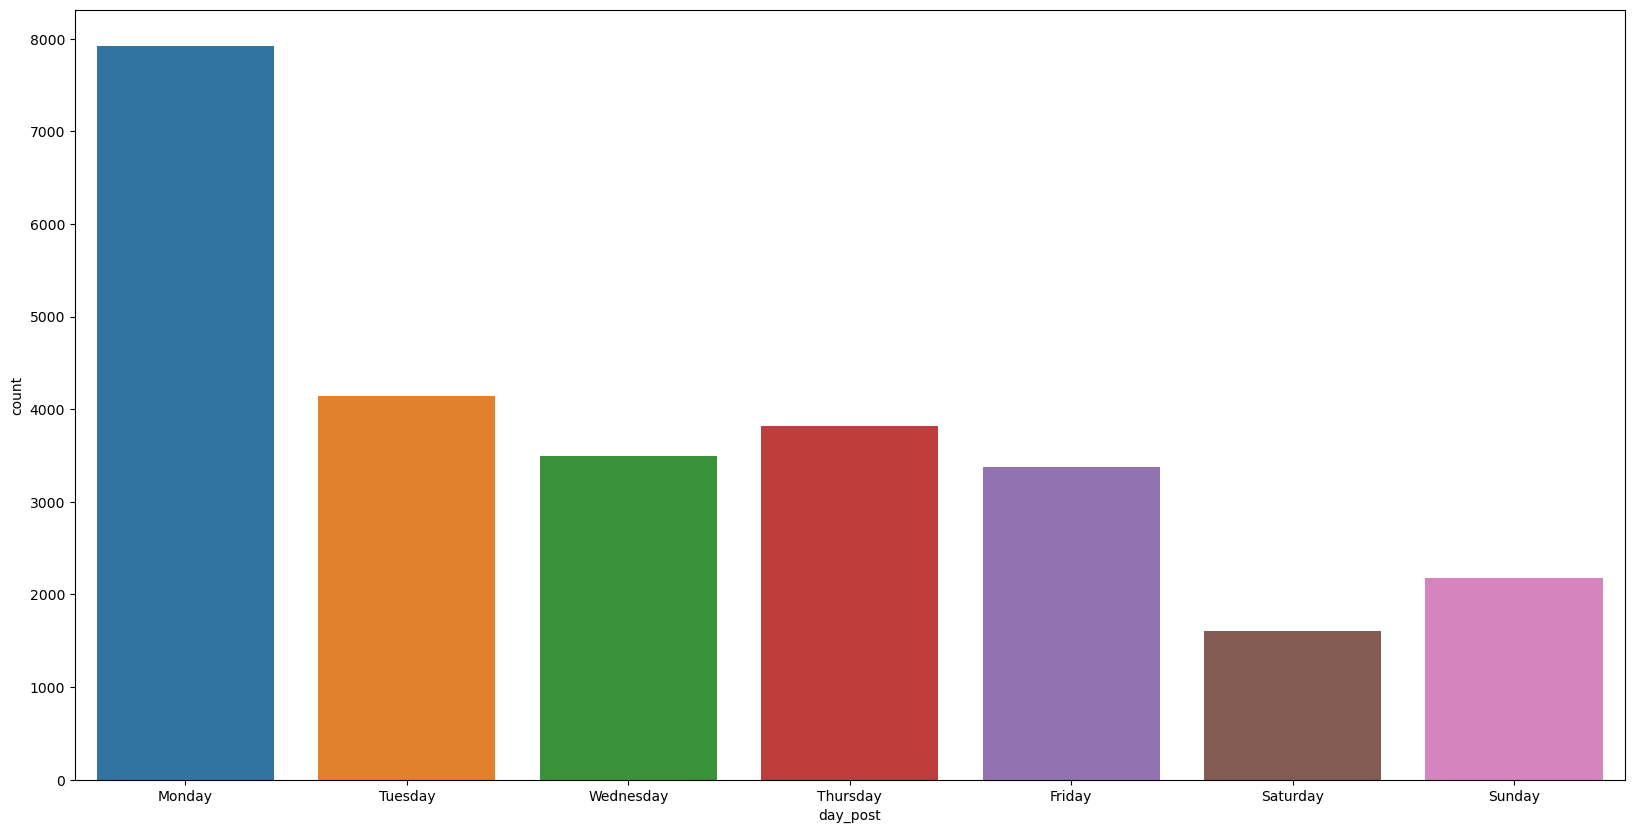

In [44]:
plt.figure(figsize=(20,10))
sns.countplot(x='day_post',data=df);

**Вывод:** Как мы можем видеть большая часть постов публикуется по понедельникам (около 8 тысяч) , это по сути и логично. После бурных выходных выкладываются новые посты. Следом идет вторник. Крайне малое значение сообщений в постах что не удивительно по субботам (менее 2-х тысяч). Выходные же всё таки.

Посмотрим на количество сообщений в тредах в общем по дням недели

<AxesSubplot:xlabel='day_threads', ylabel='count'>

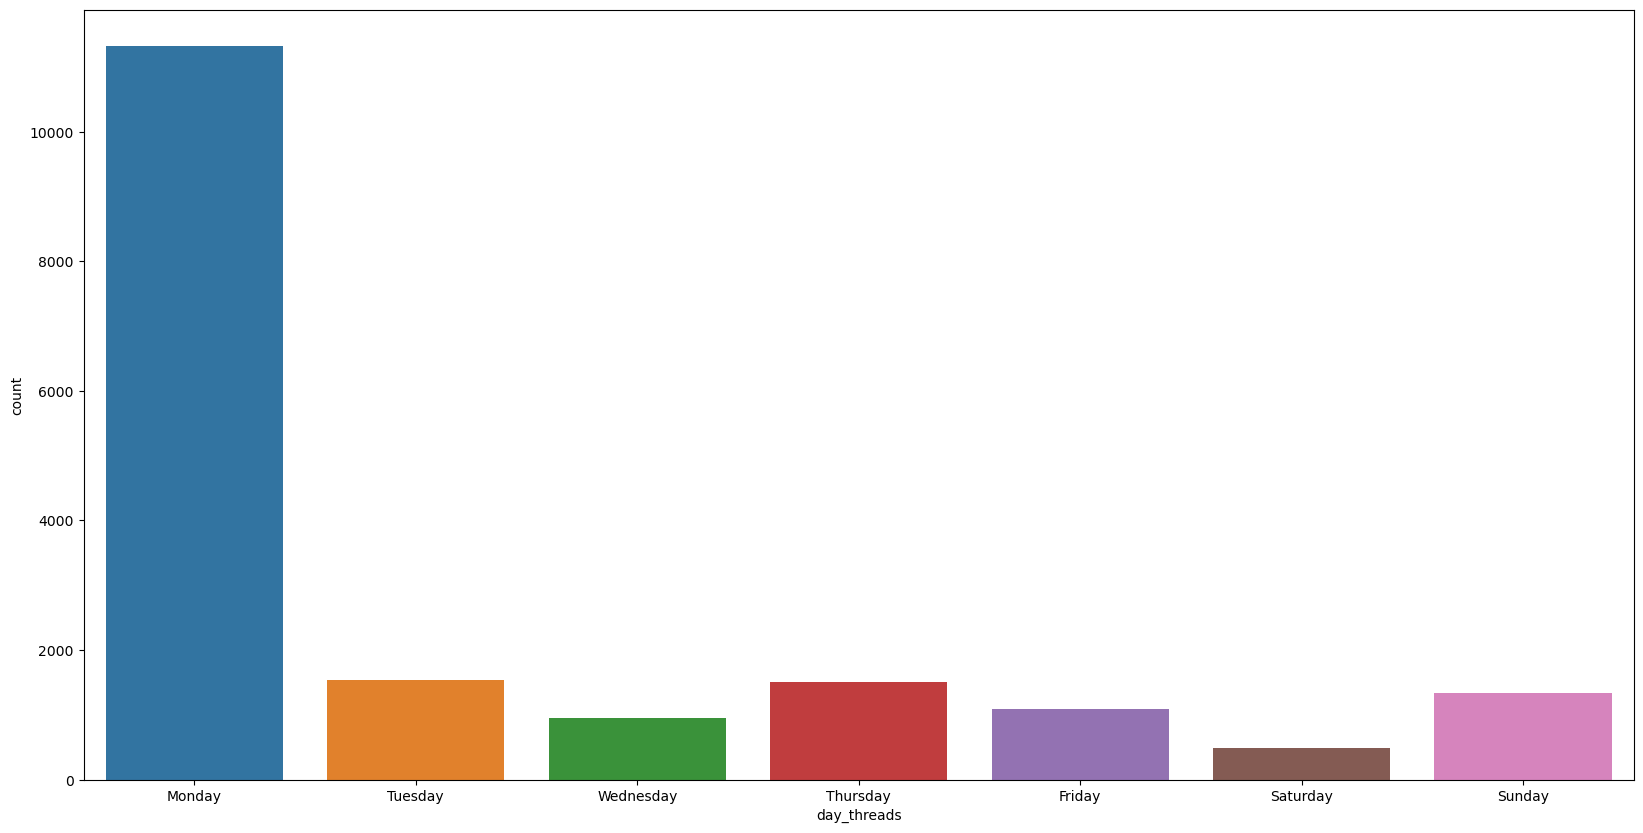

In [45]:
plt.figure(figsize=(20,10))
sns.countplot(x='day_threads',data=df)

**Выввод:** Ситуация по тредам почти похожая, что и по постам. Здесь больше всего сообщений в тредах снова в понедельник (более 10 тысяч) , следом идут вторник и четверг. Крайне малую активность по тредам занимает суббота.

Посмотрим на количество сообщений в группах с 2022.10.21 по 2023.02.09

In [46]:
df_melt = df.melt(id_vars = ['day_post'],
                  value_vars = ['date_post'],
                  var_name = 'columns')

df_melt.head()

,day_post,columns,value
0,Monday,date_post,2022-11-28 13:49:23
1,Monday,date_post,2022-11-28 14:24:08
2,Monday,date_post,2022-11-28 14:48:50
3,Tuesday,date_post,2022-11-29 08:08:12
4,Tuesday,date_post,2022-11-29 08:32:32


In [47]:
x = np.sort(df_melt["day_post"].unique())
y = df_melt["day_post"].value_counts()

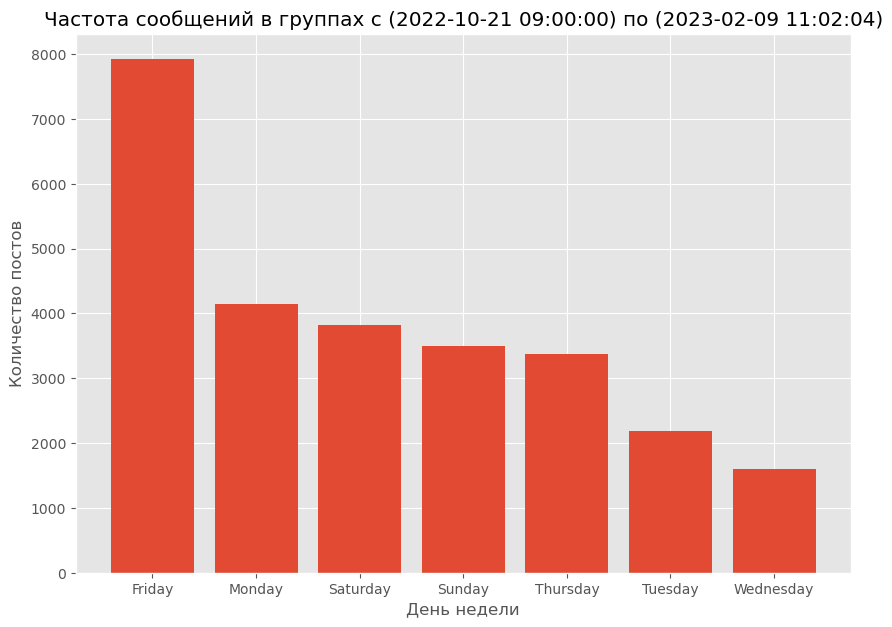

In [48]:
plt.style.use('ggplot')
fig= plt.subplots(figsize =(10, 7))
plt.bar(x, y, width=0.8, bottom=None, align='center')
mi = df["date_post"].min()
ma = df["date_post"].max()
plt.xlabel("День недели")
plt.ylabel("Количество постов")
plt.title(f"Частота сообщений в группах с ({mi}) по ({ma})")
plt.show()

**Выввод:** Лидирует по количеству сообщений friday, меньше всего в wednesday

Посмотрим на количество сообщений в категории subtype

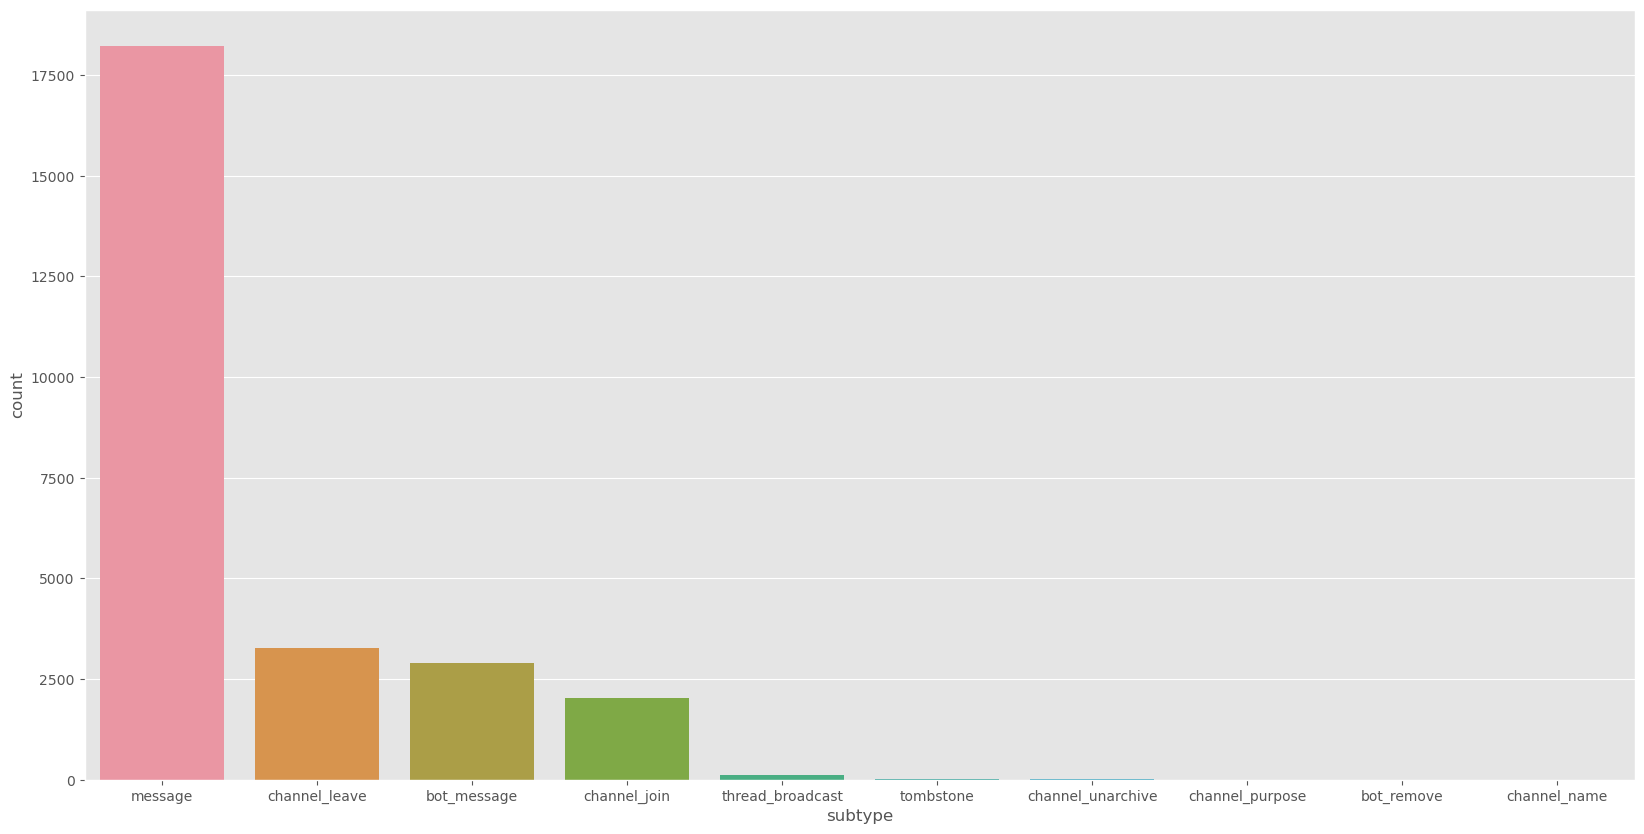

In [49]:
plt.figure(figsize=(20,10))
sns.countplot(x='subtype',data=df,order = df['subtype'].value_counts().index);

**Вывод:** Как мы видим лидирует категория message (помним, что это наши пропуски), channel_leave, следом идут bot_message и сhannel_join

In [50]:
df['channel'].value_counts().to_frame()

,channel
da_59_exerciser,1188
da_60_projects,985
ds_55_projects,905
ds_46_exerciser,512
ds_57_projects,475
...,...
de_3_exerciser,1
ds_plus_06_projects,1
de_4_exerciser,1
de_4_projects,1


In [51]:
pd.pivot_table(df, index=['channel'])

,attachments,text_len,text_words
channel,,,
da_42_exerciser,0.000000,55.000000,8.000000
da_42_projects,0.000000,55.000000,8.000000
da_50_info,0.000000,132.333333,17.571429
da_50_library,0.000000,35.000000,5.000000
da_50_teamwork,0.000000,51.033333,7.700000
...,...,...,...
sql_exerciser_new,0.000000,36.333333,5.000000
sql_info,0.021739,234.565217,31.565217
sql_info_new,0.000000,264.250000,35.400000


In [52]:
# Общее количество людей, отправивших хотя бы одно сообщение в группе;
print(f"Общее количество людей, отправивших хотя бы одно сообщение в группе {len(df.user_id.unique()) - 1}") 
print(f"Количество людей, которые не отправили ни одного сообщения в группе {23643 - len(df.user_id.unique()) - 1}")

Общее количество людей, отправивших хотя бы одно сообщение в группе 3191
Количество людей, которые не отправили ни одного сообщения в группе 20450


**Вывод:** Общее количество людей, отправивших хотя бы одно сообщение в группе 3191
Количество людей, которые не отправили ни одного сообщения в группе 20450

In [53]:
df1 = df.copy()      
df1['message_count'] = [1] * df1.shape[0]  
df1 = df1.groupby('file_date').sum().reset_index()
df1.head(5)

,file_date,attachments,text_len,text_words,message_count
0,2022-10-21,0,1472,180,3
1,2022-10-23,0,79,10,1
2,2022-10-30,0,63,10,3
3,2022-11-06,0,809,93,4
4,2022-11-07,0,2588,395,10


Топ-10 самых активных дней

In [54]:
top10days = df1.sort_values(by="message_count", ascending=False).head(10)   
top10days.reset_index(inplace=True)           
top10days.drop(columns="index", inplace=True) 
top10days

,file_date,attachments,text_len,text_words,message_count
0,2022-11-28,27,353486,47226,2487
1,2022-11-27,10,241714,34876,2453
2,2022-12-05,16,319329,42300,1995
3,2022-12-01,17,276126,36544,1880
4,2022-12-06,28,282264,37861,1748
5,2022-11-29,32,287884,38836,1729
6,2022-12-02,18,279993,37294,1707
7,2022-12-08,12,277747,36594,1606
8,2022-11-30,11,253880,33621,1560
9,2022-12-09,8,226067,31125,1381


Определили топ 10, отрисуем на графике

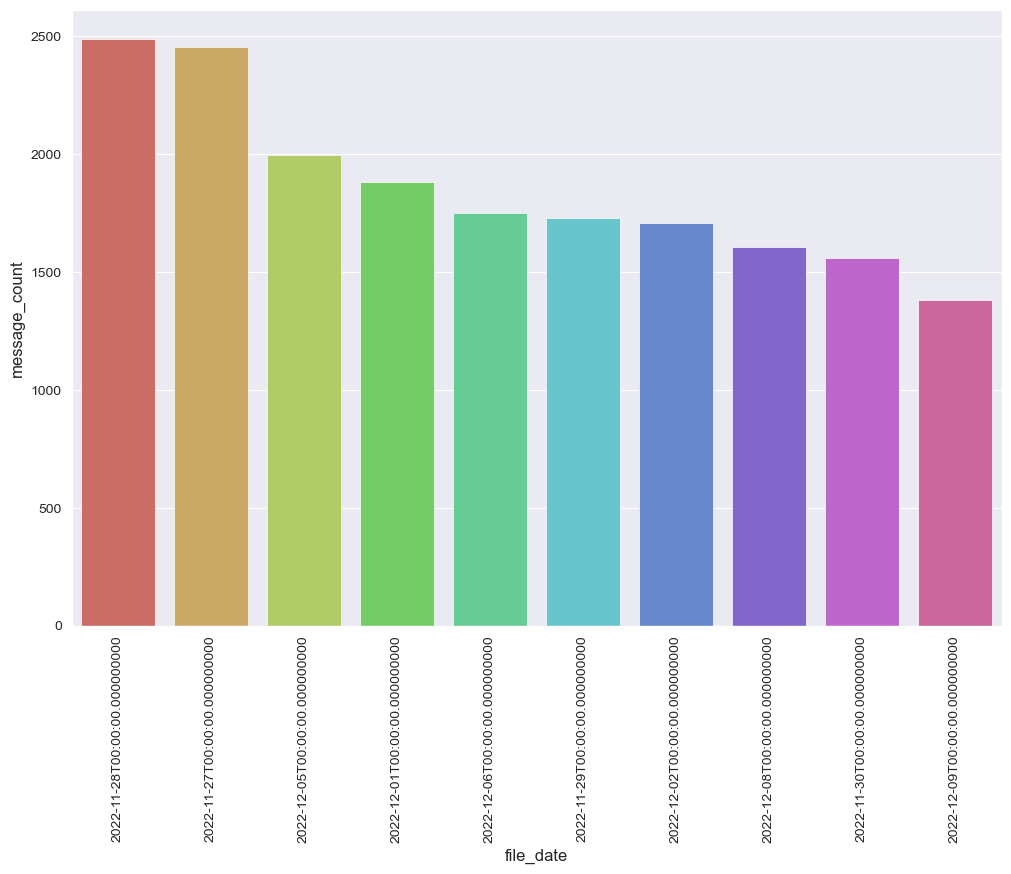

In [55]:
sns.set_style("darkgrid")
import matplotlib
matplotlib.rcParams['font.size'] = 10
matplotlib.rcParams['figure.figsize'] = (12, 8)
sns.barplot(top10days.file_date, top10days.message_count, palette="hls");
plt.savefig('top10_days.svg', format = 'svg')
plt.xticks(rotation = 90);

**Вывод:** Больше всего сообщений было отправлено 28 ноября 2022 года, меньше всего в 9 декабря 2022 года

Посмотрим на количество сообщений отправленных за всё время

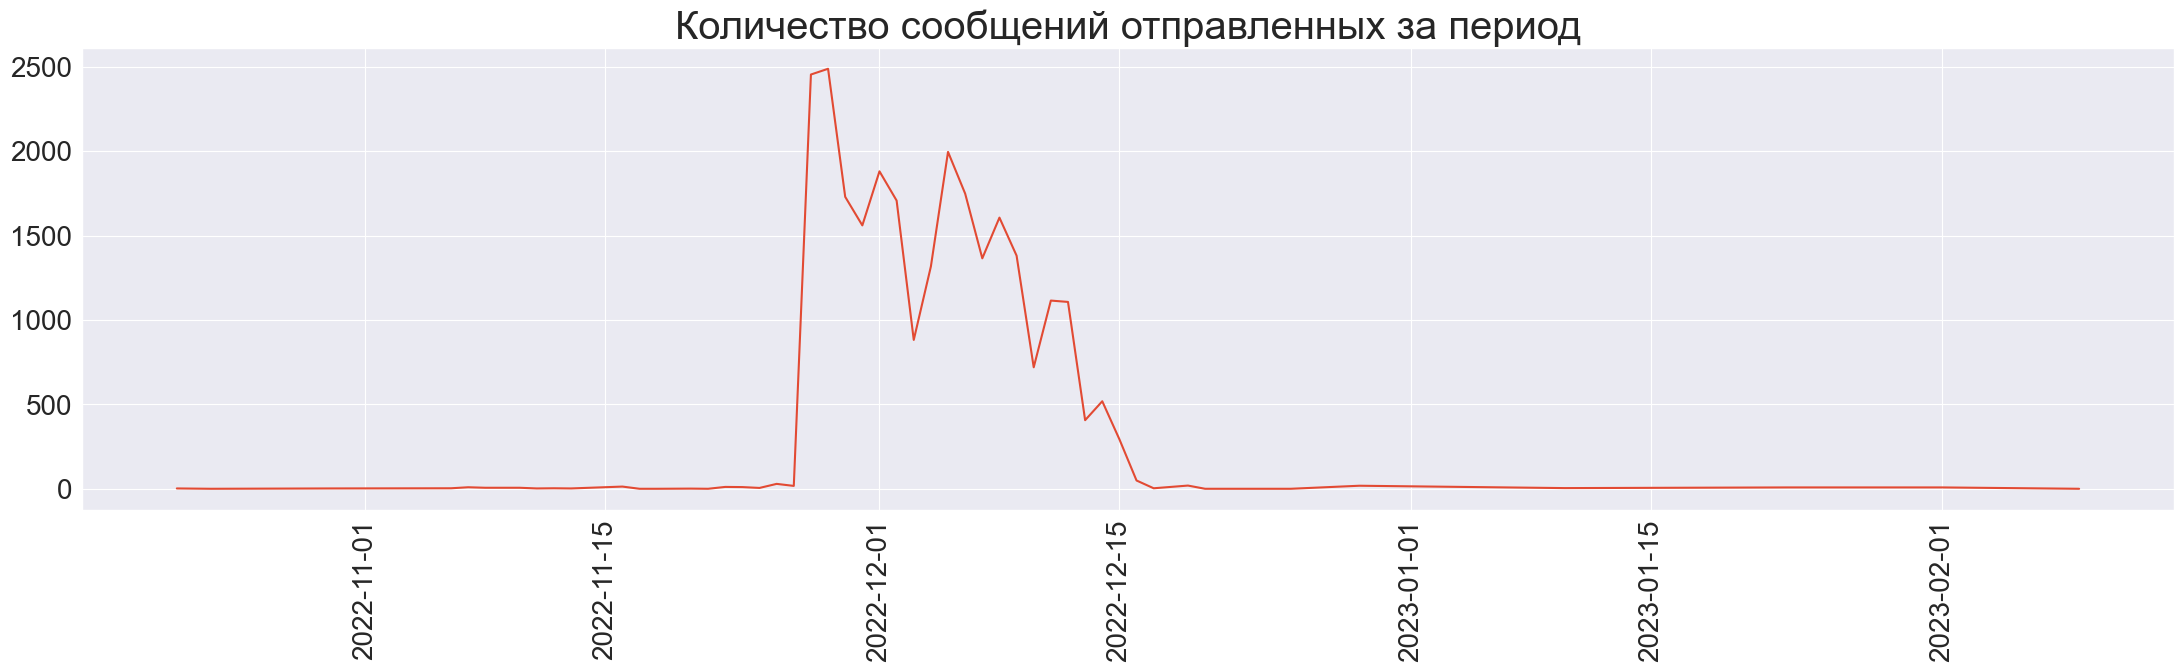

In [56]:
sns.set_style("darkgrid")
import matplotlib
matplotlib.rcParams['font.size'] = 20
matplotlib.rcParams['figure.figsize'] = (27, 6)

plt.plot(df1.file_date, df1.message_count)
plt.title('Количество сообщений отправленных за период');
plt.xticks(rotation = 90)
plt.savefig('msg_plots.svg', format = 'svg')

**Вывод:** По этому графику можно посмотреть, что до 26 ноября практически не было сообщений. Затем резкий всплеск и максимум 28 ноября, затем снова спад. Видна закономерность увеличения сообщений и спада, как раз на длину спринтов. Это такое предположение.

Подготовка

In [57]:
df3 = df.copy()
df3['message_count'] = [1] * df.shape[0]    

df3['hour'] = df3['date_post'].apply(lambda x: x.hour)

grouped_by_time = df3.groupby('hour').sum().reset_index().sort_values(by = 'hour')

В какое время суток чаще всего обмениваются сообщениями?

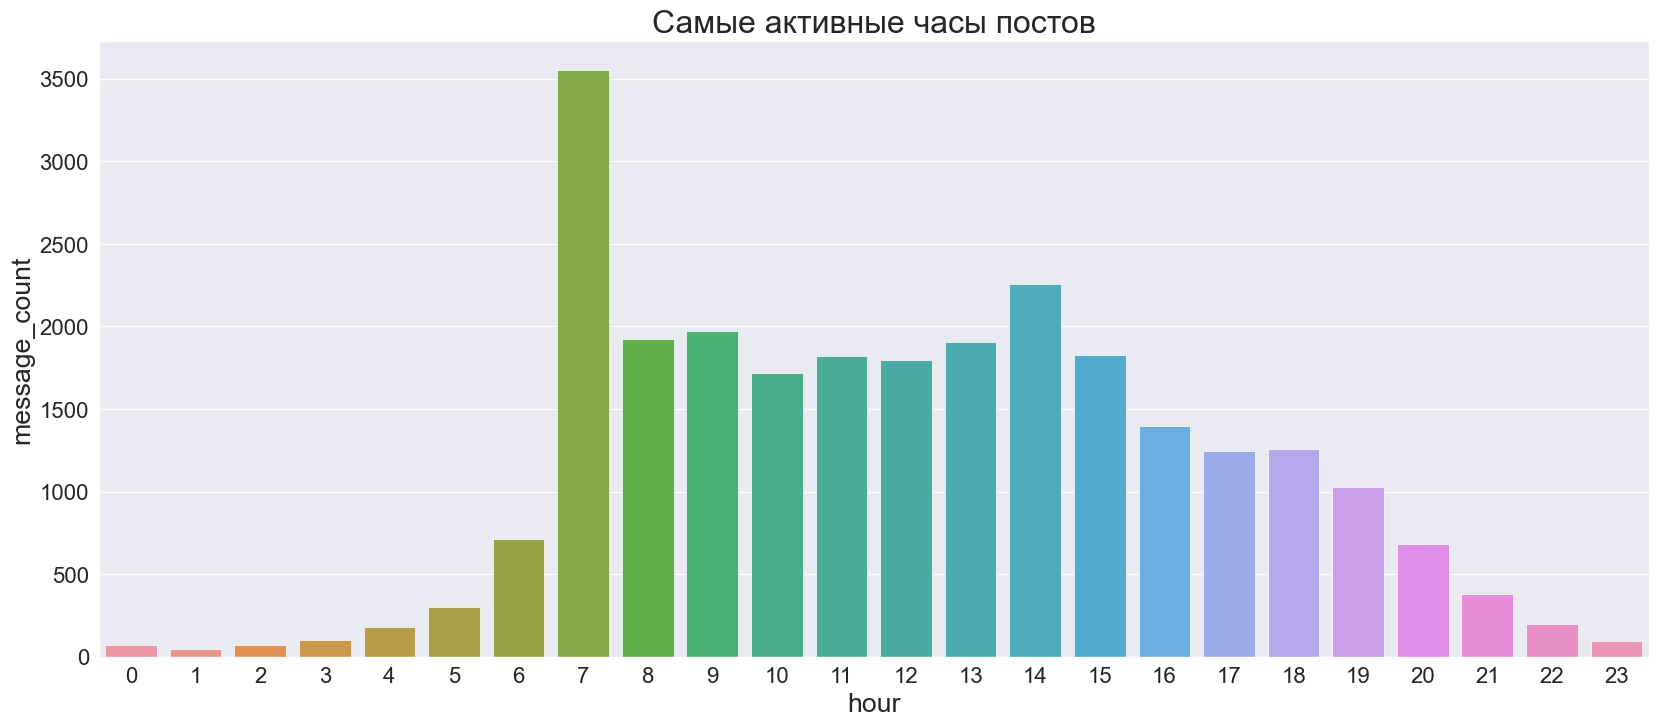

In [58]:
import matplotlib
matplotlib.rcParams['font.size'] = 16
matplotlib.rcParams['figure.figsize'] = (20, 8)
sns.set_style("darkgrid")
sns.barplot(grouped_by_time.hour, grouped_by_time.message_count)
plt.title('Самые активные часы постов');
plt.savefig('most_active_hours.svg', format = 'svg')

**Вывод:** Судя по графику можно сделать такие выводы. Что чаще всего отправляют сообщения в районе 7 часов, то есть рано утром это более 3500 сообщений. Следом можно выделить 14 часов после обеденное время, когда чуть меньше 2500 сообщений. Средние показатели с 7 часов и до 14 часов. После 15 часов видно, что количество сообщений идет на спад

In [59]:
df.head(5)

,client_msg_id,user_id,date_post,latest_reply,date_threads,subtype,channel,file_date,attachments,text_len,text_words,day_post,day_threads,reaction_names,reaction_users,reaction_counts
0,ae31e785-257b-4290-a4c6-9721337f67ea,U03JYMWQLP5,2022-11-28 13:49:23,2022-11-28 14:24:08,2022-11-28 13:49:23,message,data-analysts-bus,2022-11-28,0,297,47,Monday,Monday,,,
1,7f644ae8-16d4-4c9e-9c4f-8b2d6df6a28d,U03V483FRKM,2022-11-28 14:24:08,NaT,2022-11-28 13:49:23,message,data-analysts-bus,2022-11-28,0,434,63,Monday,Monday,pray,U03JYMWQLP5,1
2,0,U02KVQJHQ5S,2022-11-28 14:48:50,NaT,0,channel_join,data-analysts-bus,2022-11-28,0,37,5,Monday,NaN,,,
3,6c5bf2c1-8579-413c-8e8f-ec3a0e3698a8,U03JYMWQLP5,2022-11-29 08:08:12,2022-11-29 10:56:57,2022-11-29 08:08:12,message,data-analysts-bus,2022-11-29,0,69,12,Tuesday,Tuesday,cat-high-five,U040E2D6CF2,1
4,b5e3413b-8f04-4192-948b-2423eb3192b2,U040E2D6CF2,2022-11-29 08:32:32,NaT,2022-11-29 08:08:12,message,data-analysts-bus,2022-11-29,0,19,2,Tuesday,Tuesday,,,


Топ 10 каналов по количеству реакций

In [60]:
top10reactions = df.groupby("channel")["reaction_counts"].count().sort_values(ascending=False)

In [61]:
top10reactions = top10reactions.head(10).reset_index()
top10reactions

,channel,reaction_counts
0,da_59_exerciser,1188
1,da_60_projects,985
2,ds_55_projects,905
3,ds_46_exerciser,512
4,ds_57_projects,475
5,ds_55_teamwork,452
6,ds_58_projects,439
7,da_62_projects,431
8,ds_57_teamwork,411
9,da_63_exerciser,386


**Вывод:** Как мы видим больше всего реакций выражает канал da_59_exerciser (1188 реакций), меньше всего в da_63_exerciser	 (386 реакций) 

In [62]:
top10df = df.groupby("channel")["user_id"].count().sort_values(ascending=False)

In [63]:
top10df = top10df.head(10).reset_index()
top10df

,channel,user_id
0,da_59_exerciser,1188
1,da_60_projects,985
2,ds_55_projects,905
3,ds_46_exerciser,512
4,ds_57_projects,475
5,ds_55_teamwork,452
6,ds_58_projects,439
7,da_62_projects,431
8,ds_57_teamwork,411
9,da_63_exerciser,386


Анализ сообщений и рекаций по каналам

In [64]:
df['chan']=df['channel']
def lens_2(df: pd.DataFrame, col: str):
    for i in range(len(df[col])):
        df['chan'][i] = df[col][i][0:3]
lens_2(df,'channel')

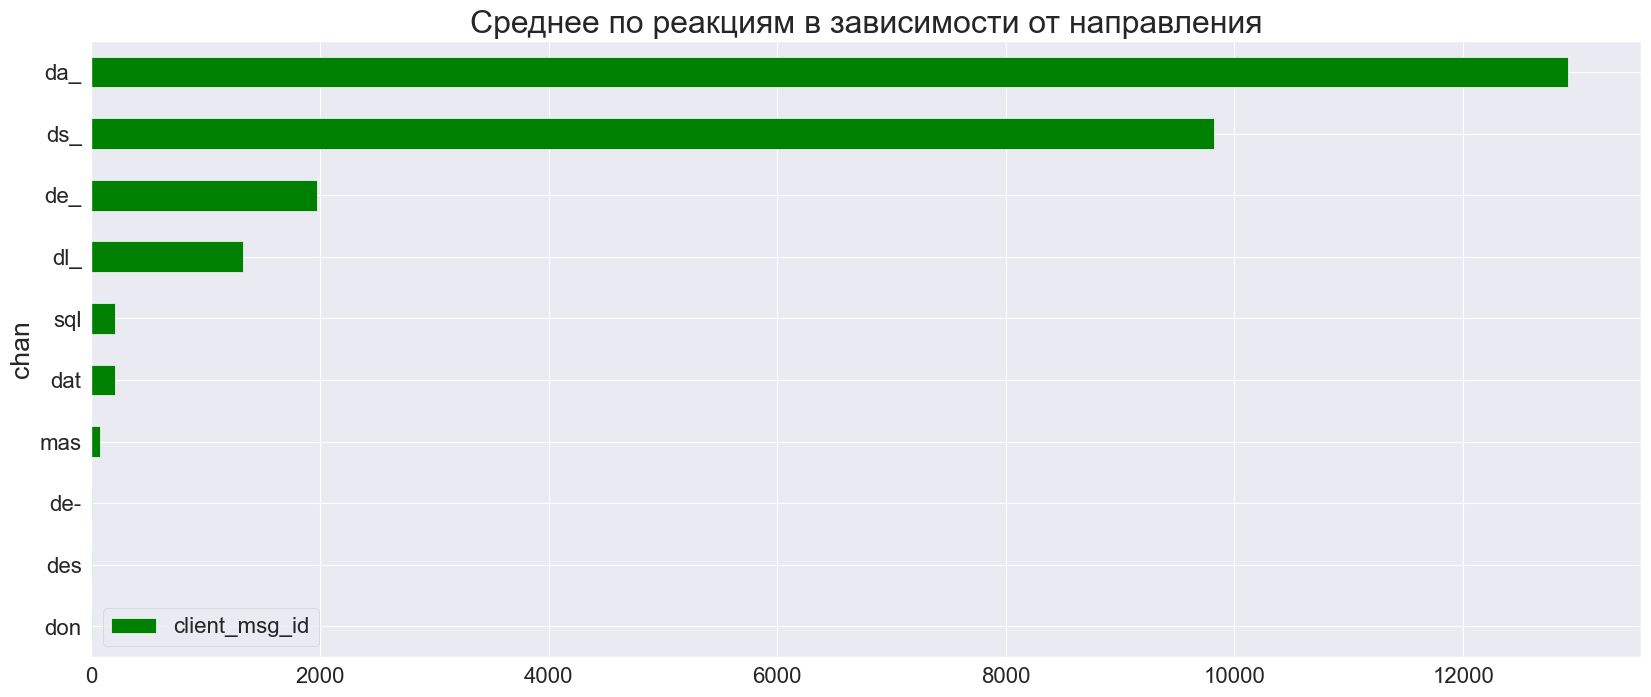

In [65]:
df[['client_msg_id','chan']] \
    .groupby('chan').agg('count') \
    .sort_values(by='client_msg_id') \
    .plot(title='Среднee по реакциям в зависимости от направления', kind='barh', color='g');

**Вывод:** Лидируют такие каналы как da, ds, de, dl

Анализ по когортам

In [66]:
df['split']=df['channel']

In [67]:
def lens_3(df: pd.DataFrame, col: str):
    for i in range(len(df[col])):
        df[col][i] = re.split("_|-",df[col][i])
        a =df[col][i]
        try:
            if df[col][i][0]=='data' or df[col][i][0]=='sql' :
                df[col][i] = a[-2]
            else:
                df[col][i] = a[-1]
        except:
            df[col][i] = df[col][i]

lens_3(df,'split')

In [68]:
df['splits']=df['split']
for i in range(len(df['splits'])):
    df['splits'][i] = ''.join(df['splits'][i])

In [69]:
df['splits'].unique()

array(['analysts', 'logs', 'data', 'edteam', 'exerciser', 'projects',
       'info', 'library', 'teamwork', 'digitalprof', 'профессии',
       'project', 'b2g', 'mentors', 'apps', 'telecom', 'study', 'kt',
       'pro1', 'pro2', 'pro3', 'pro4', 'plus', 'community', 'group',
       'tutorial', 'blue', 'problem', 'topic1', 'topic2', 'topic3',
       'professions', 'project1', 'coffee', 'feedback', 'me', 'academ',
       'donorsearch', '04', 'sql'], dtype=object)

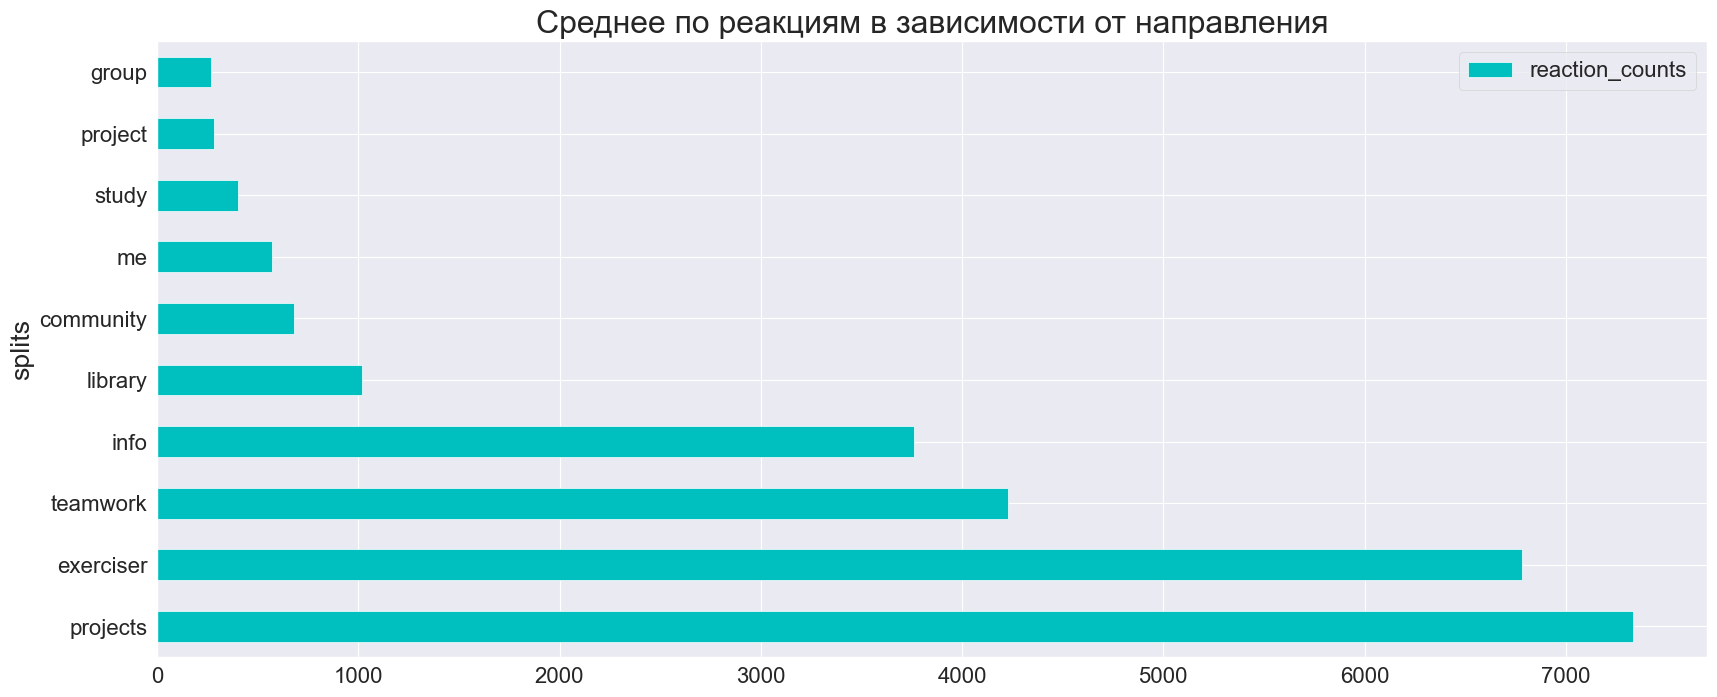

In [70]:
a=df[['reaction_counts','splits']].groupby('splits').agg('count') \
    .sort_values(by='reaction_counts', ascending=False).head(10)
a.plot(title='Среднee по реакциям в зависимости от направления', kind='barh', color = 'c');

**Вывод:** Чаще всего общаются в когортах projects и exercise

Самые активные пользователи

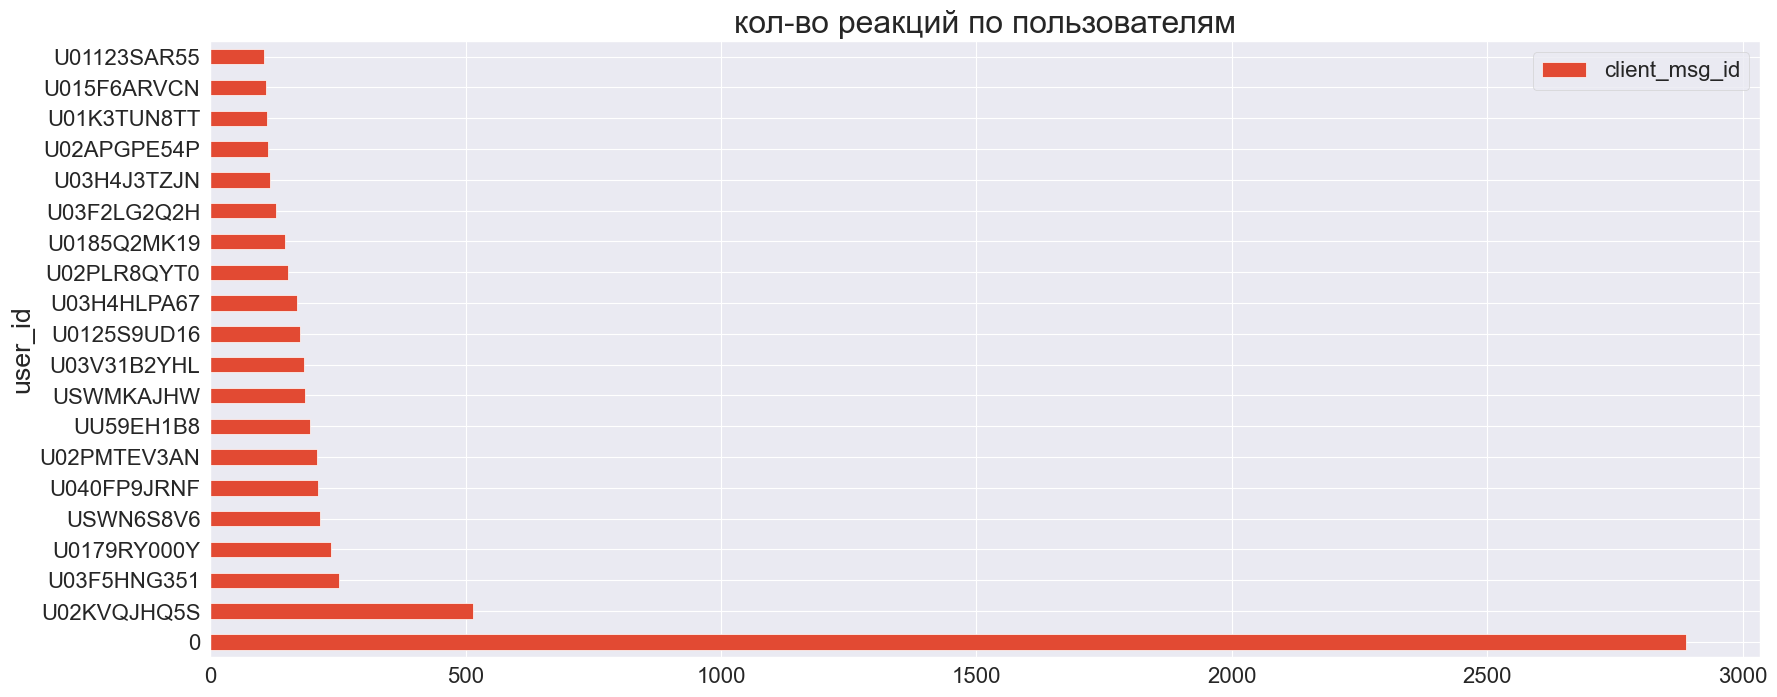

In [71]:
top_user = df[['client_msg_id','user_id']] \
    .groupby('user_id').agg('count') \
    .sort_values(by='client_msg_id', ascending=False)
top_user = top_user.head(20)
top_user.plot(title='кол-во реакций по пользователям', kind='barh');

**Вывод:** Самым активным оказался пользователь U02KVQJHQ5S. Посмторим на него поближе

Посмотрим на самого активного

In [72]:
df.query('user_id == "U02KVQJHQ5S"')

,client_msg_id,user_id,date_post,latest_reply,date_threads,subtype,channel,file_date,attachments,text_len,text_words,day_post,day_threads,reaction_names,reaction_users,reaction_counts,chan,split,splits
2,0,U02KVQJHQ5S,2022-11-28 14:48:50,NaT,0,channel_join,data-analysts-bus,2022-11-28,0,37,5,Monday,NaN,,,,dat,analysts,analysts
252,0,U02KVQJHQ5S,2022-12-07 15:43:05,NaT,0,channel_join,da_50_info,2022-12-07,0,37,5,Wednesday,NaN,,,,da_,info,info
278,0,U02KVQJHQ5S,2022-12-07 15:43:13,NaT,0,channel_join,da_50_library,2022-12-07,0,37,5,Wednesday,NaN,,,,da_,library,library
308,0,U02KVQJHQ5S,2022-12-07 15:43:36,NaT,0,channel_join,da_50_teamwork,2022-12-07,0,37,5,Wednesday,NaN,,,,da_,teamwork,teamwork
346,0,U02KVQJHQ5S,2022-12-07 14:24:06,NaT,0,channel_join,da_52_exerciser,2022-12-07,0,37,5,Wednesday,NaN,,,,da_,exerciser,exerciser
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26497,0,U02KVQJHQ5S,2022-11-30 13:44:23,NaT,0,channel_join,sql_teamwork,2022-11-30,0,37,5,Wednesday,NaN,,,,sql,sql,sql
26498,0,U02KVQJHQ5S,2022-11-30 13:46:57,NaT,0,channel_leave,sql_teamwork,2022-11-30,0,35,5,Wednesday,NaN,,,,sql,sql,sql
26501,0,U02KVQJHQ5S,2022-12-13 13:21:27,NaT,0,channel_join,sql_teamwork,2022-12-13,0,37,5,Tuesday,NaN,,,,sql,sql,sql
26514,0,U02KVQJHQ5S,2022-11-30 13:45:04,NaT,0,channel_join,sql_teamwork,2022-11-30,0,37,5,Wednesday,NaN,,,,sql,sql,sql


**Вывод:** Оказался этот пользователь обычным ботом. Фигурирует почти по всем каналам.

Досоздадим недостающие колонки для анализа

In [73]:
df['date_post_week']=df['date_post'].dt.weekday #создаю столбец с днем недели
df['date_post_month']=df['date_post'].dt.month #создаю столбец с месяцем
df['date_post_year']=df['date_post'].dt.year #создаю столбец с годом
df['date_post_hour'] = df['date_post'].dt.hour

Определим функцию для постройки графиков

In [74]:
def plot_rat_time(x,y, ttle):
    df[[x,y]] \
    .groupby(y).agg('count') \
    .plot(title=ttle, kind='bar',\
         color = 'c')

def plot_rat(x,y, ttle):
    df[[x,y]] \
    .groupby(y).agg('count') \
    .sort_values(by=x, ascending=False) \
    .plot(title=ttle, kind='bar')

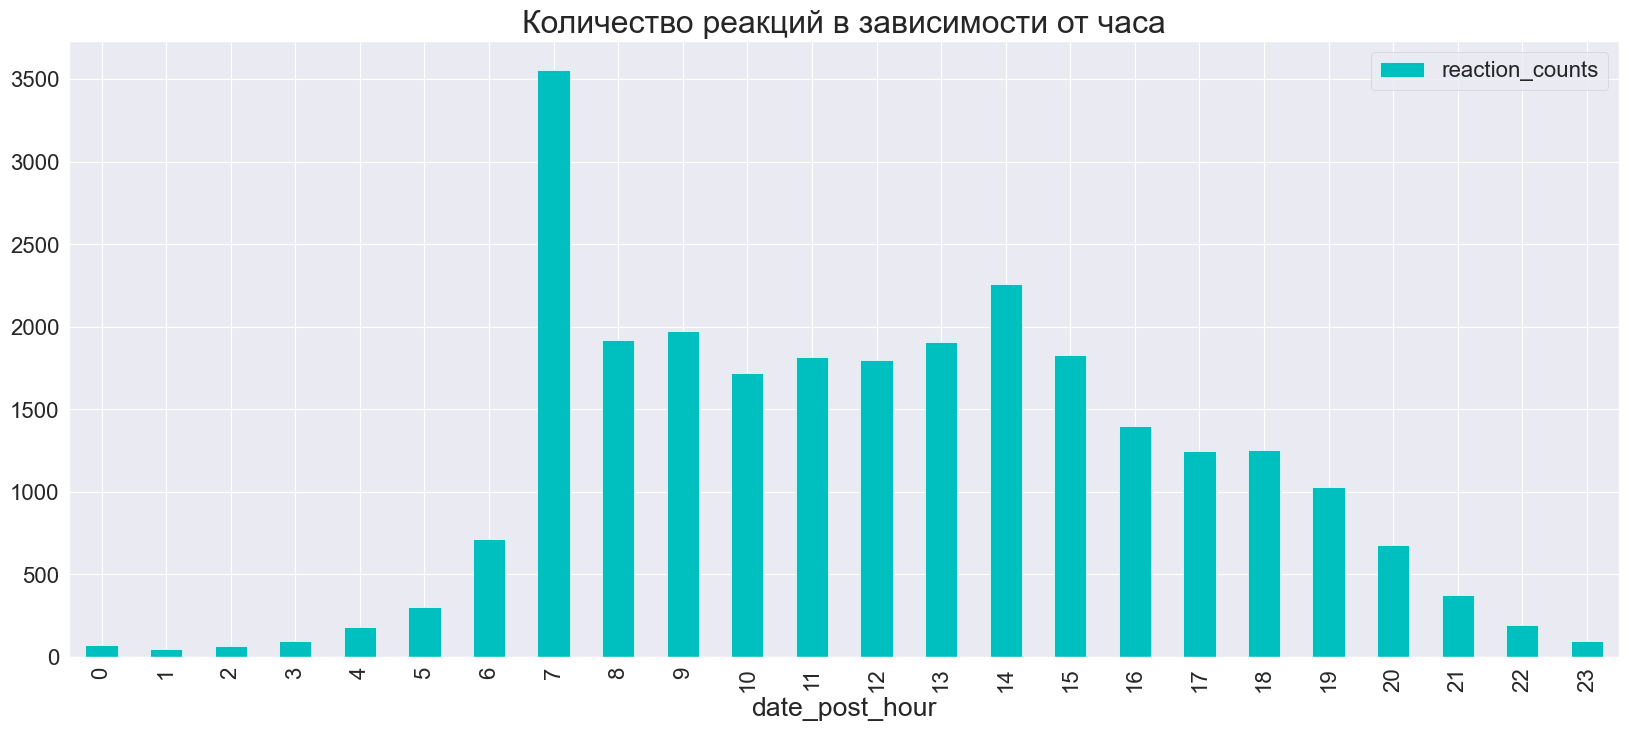

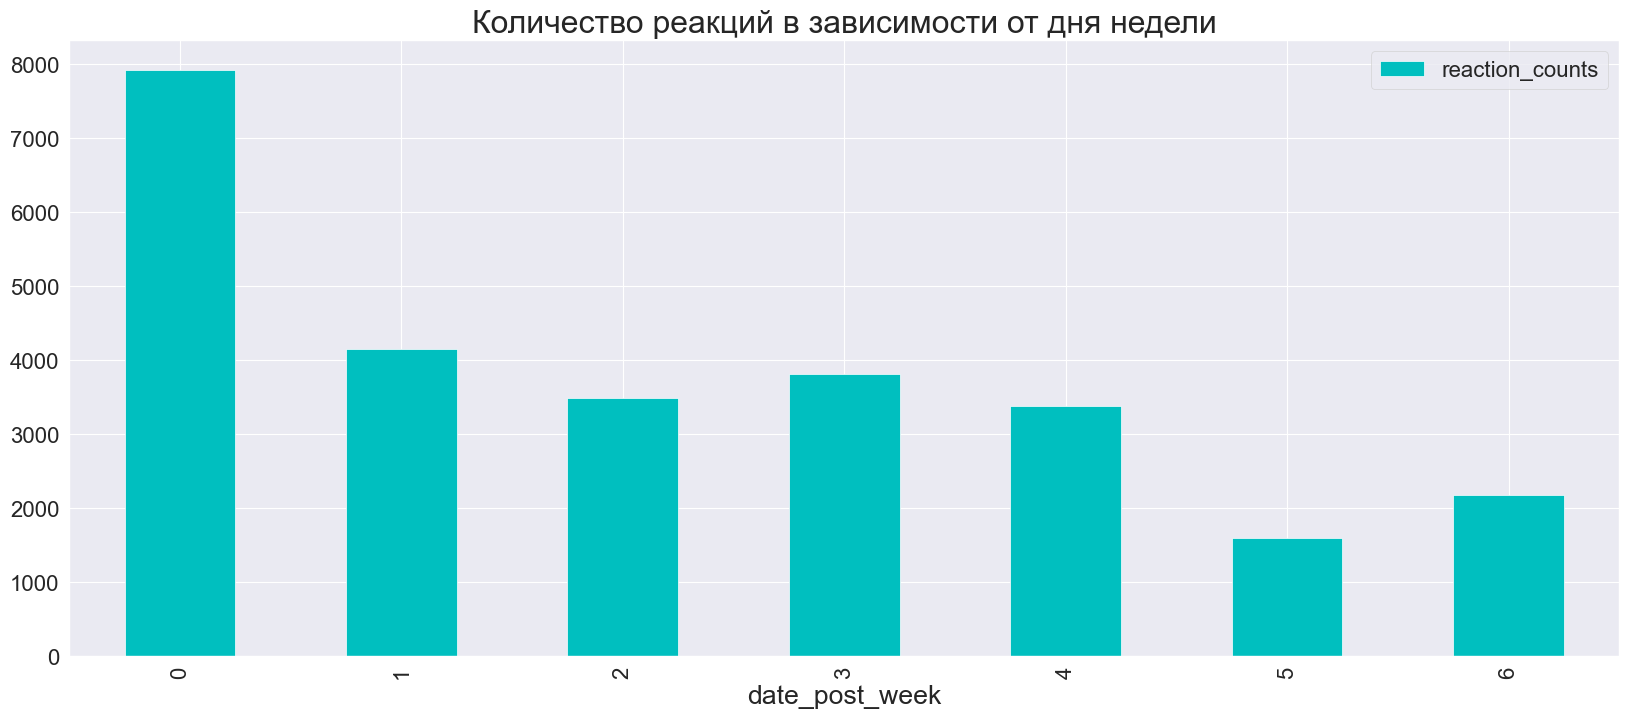

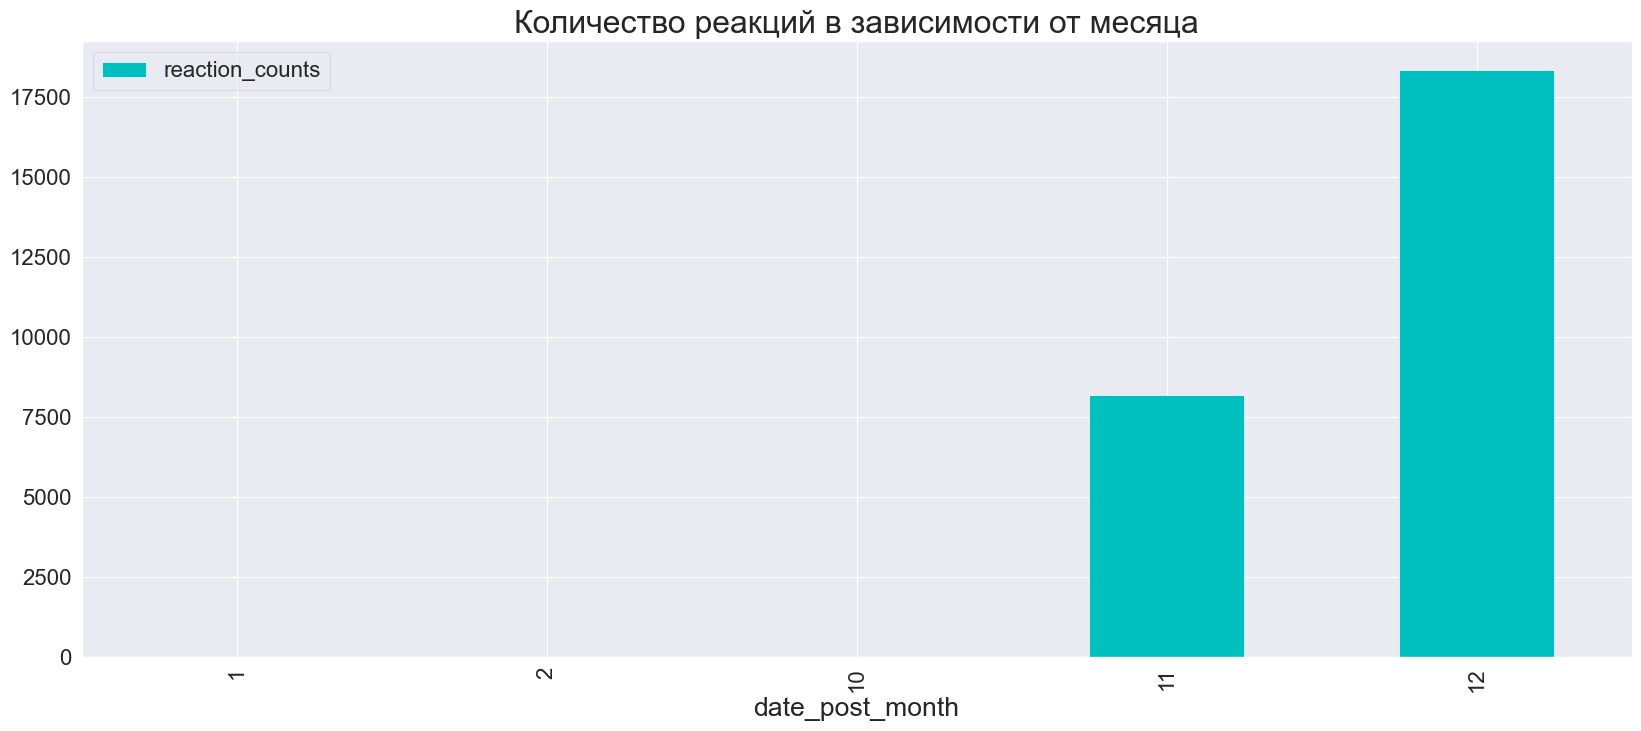

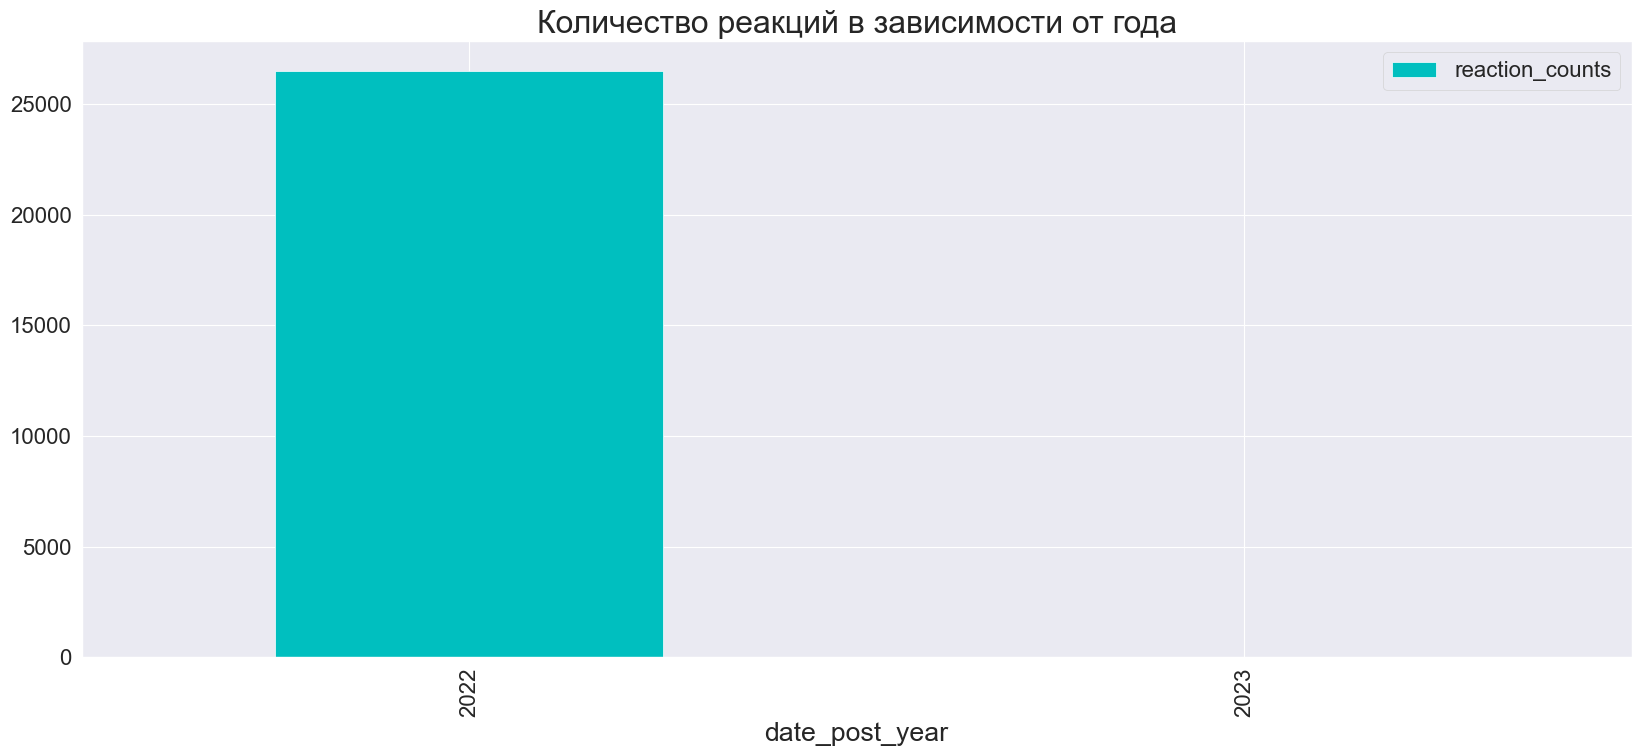

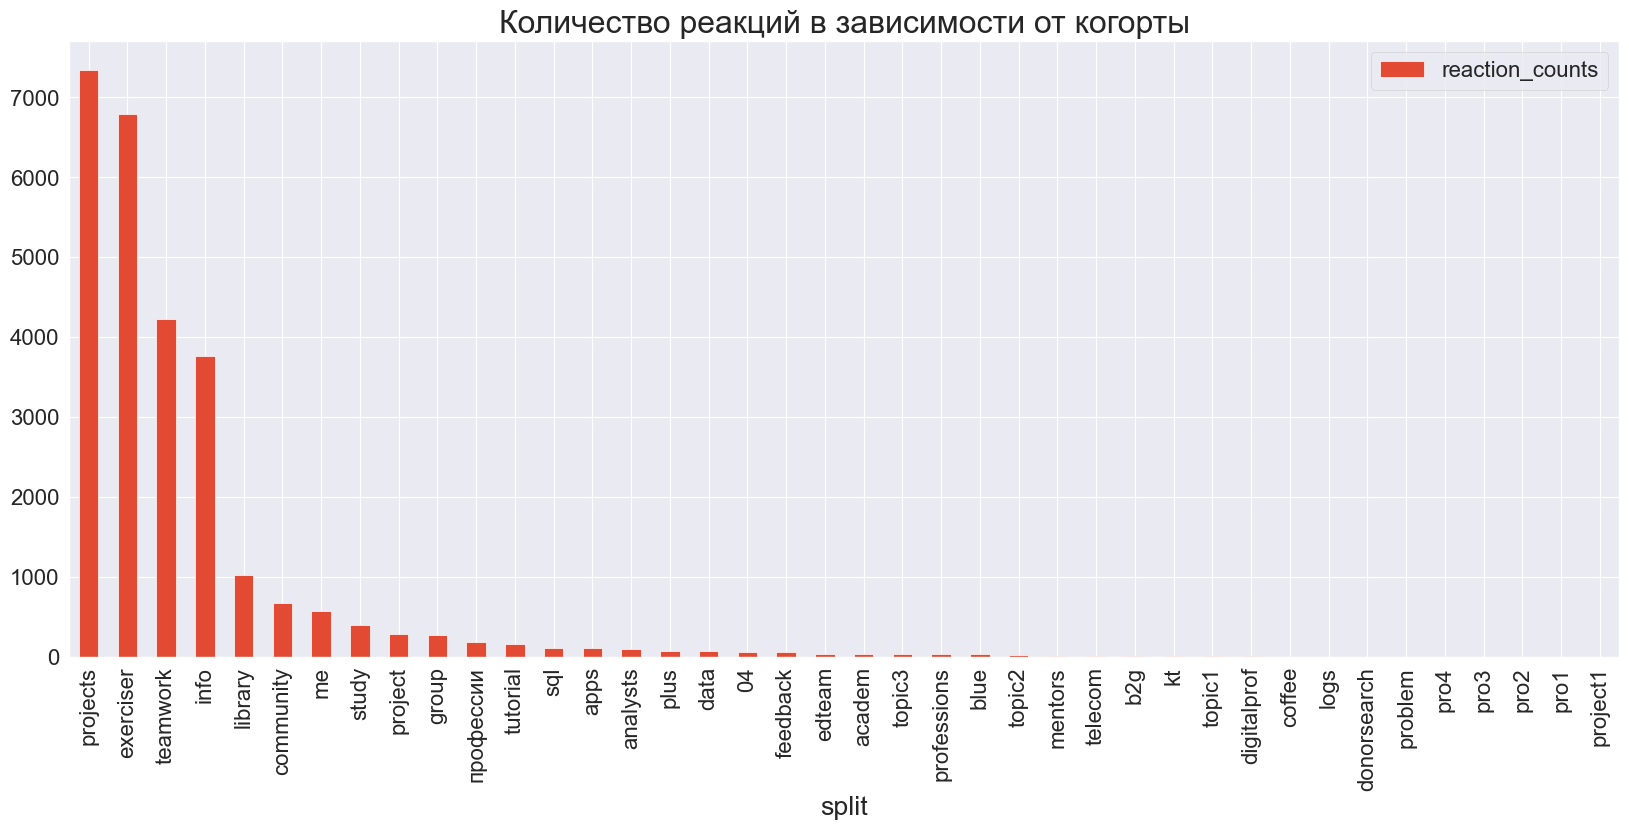

In [75]:
plot_rat_time('reaction_counts','date_post_hour','Количество реакций в зависимости от часа')
plot_rat_time('reaction_counts','date_post_week','Количество реакций в зависимости от дня недели')
plot_rat_time('reaction_counts','date_post_month','Количество реакций в зависимости от месяца')
plot_rat_time('reaction_counts','date_post_year','Количество реакций в зависимости от года')
plot_rat('reaction_counts','split','Количество реакций в зависимости от когорты')


**Вывод:** Чаще рейтинги ставили на сообщения в 7:00 и 14:00 дня, в понедельник и в декабре.
Хуже ставили ночью: с 0:00 до 3:00 и в 23:00. По дням недели в субботу,а по месяцам в октябре.
Число реакций больше в каналах project и exerciser.
Чаще реации ставят пользватели в группах по профессиям DA И DS.

Определим по количеству написанных символов пользователей

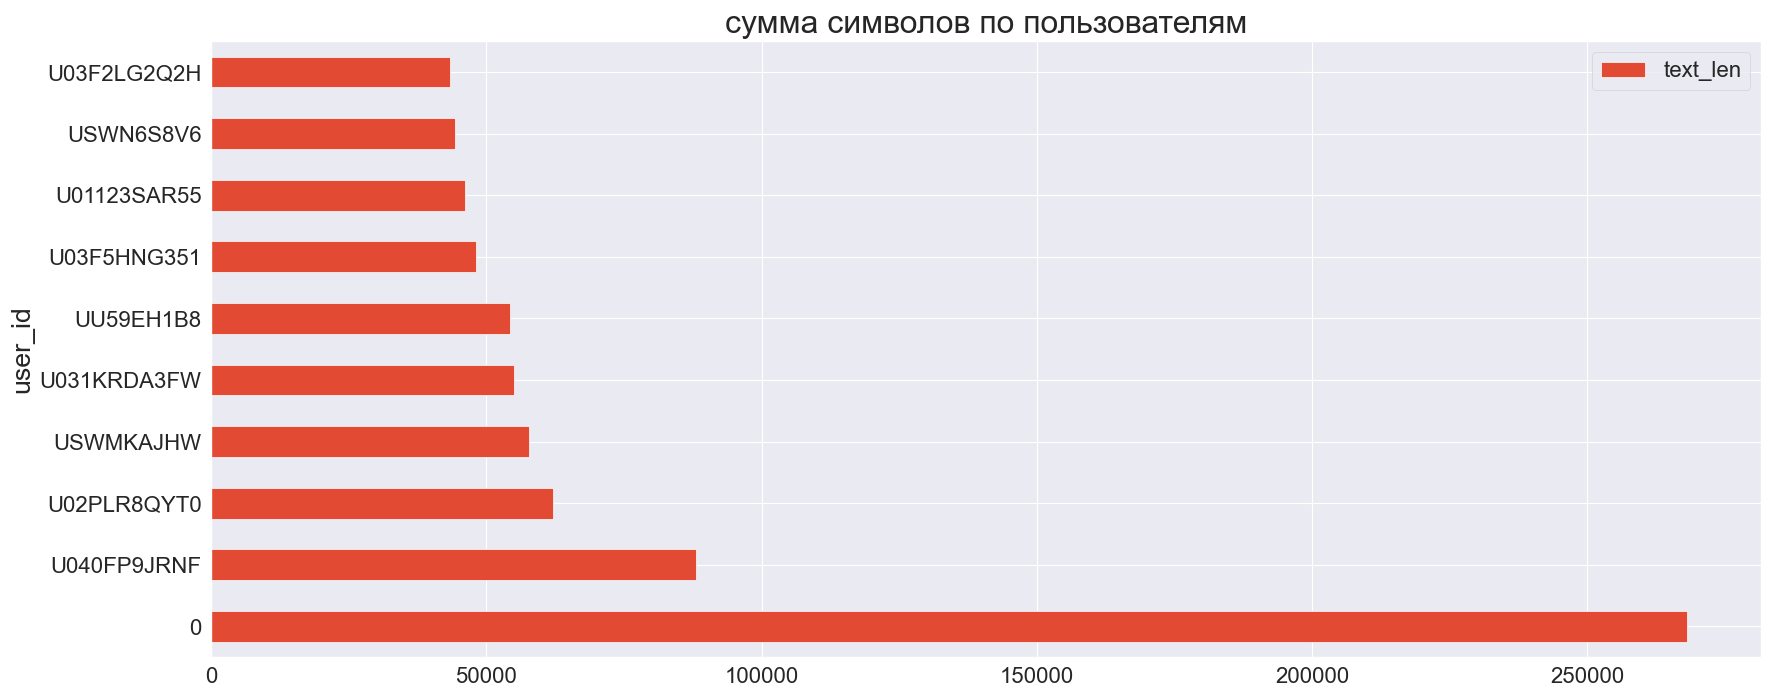

In [76]:
top_user = df[['text_len','user_id']] \
    .groupby('user_id').agg('sum') \
    .sort_values(by='text_len', ascending=False)
top_user = top_user.head(10)
top_user.plot(title='сумма символов по пользователям', kind='barh');

In [77]:
df.query('user_id == "U040FP9JRNF"')

,client_msg_id,user_id,date_post,latest_reply,date_threads,subtype,channel,file_date,attachments,text_len,...,reaction_names,reaction_users,reaction_counts,chan,split,splits,date_post_week,date_post_month,date_post_year,date_post_hour
4630,bc437b03-f262-4bd9-81ae-29ca62696362,U040FP9JRNF,2022-11-28 18:50:43,NaT,2022-11-28 07:01:05,message,da_59_exerciser,2022-11-28,0,285,...,+1,U042FS9AK4M,1,da_,exerciser,exerciser,0,11,2022,18
4636,d95869cd-9bee-4c4e-b570-6e355fa05bf6,U040FP9JRNF,2022-11-29 10:36:06,NaT,2022-11-28 07:01:05,message,da_59_exerciser,2022-11-29,0,140,...,,,,da_,exerciser,exerciser,1,11,2022,10
4638,5363cf1c-baeb-40c3-8960-d573e054c07b,U040FP9JRNF,2022-11-29 10:52:15,NaT,2022-11-28 07:01:05,message,da_59_exerciser,2022-11-29,0,135,...,,,,da_,exerciser,exerciser,1,11,2022,10
4644,99247968-5df8-4833-b44c-9b06d622eaaa,U040FP9JRNF,2022-11-29 16:32:54,NaT,2022-11-28 07:01:05,message,da_59_exerciser,2022-11-29,0,381,...,,,,da_,exerciser,exerciser,1,11,2022,16
4646,2cf4811b-c910-473d-bc78-de4ccb83fec7,U040FP9JRNF,2022-11-29 17:46:08,NaT,2022-11-28 07:01:10,message,da_59_exerciser,2022-11-29,0,383,...,cat-high-five,U042C74USGN,1,da_,exerciser,exerciser,1,11,2022,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9699,5469f3f7-228c-441a-9028-135835c76a8f,U040FP9JRNF,2022-12-12 14:23:18,NaT,2022-11-28 07:00:46,message,da_62_projects,2022-12-12,0,436,...,,,,da_,projects,projects,0,12,2022,14
9703,7caa5994-e34d-4776-959f-389590114d12,U040FP9JRNF,2022-12-12 17:30:48,NaT,2022-11-28 07:00:47,message,da_62_projects,2022-12-12,0,547,...,,,,da_,projects,projects,0,12,2022,17
9705,ec50f312-d0ec-4960-b4ed-00770a991290,U040FP9JRNF,2022-12-13 08:29:37,NaT,2022-11-28 07:00:47,message,da_62_projects,2022-12-13,0,436,...,cat-high-five,U048CEP8XFU,1,da_,projects,projects,1,12,2022,8
9707,a8d50f24-96e2-479f-b5e4-59713b606000,U040FP9JRNF,2022-12-14 14:58:20,NaT,2022-11-28 07:00:50,message,da_62_projects,2022-12-14,0,260,...,,,,da_,projects,projects,2,12,2022,14


**Вывод:** Лидирует юзер U040FP9JRNF. Не похож на бота. А похож на настоящего ученика

Определим по сумме слов пользователей

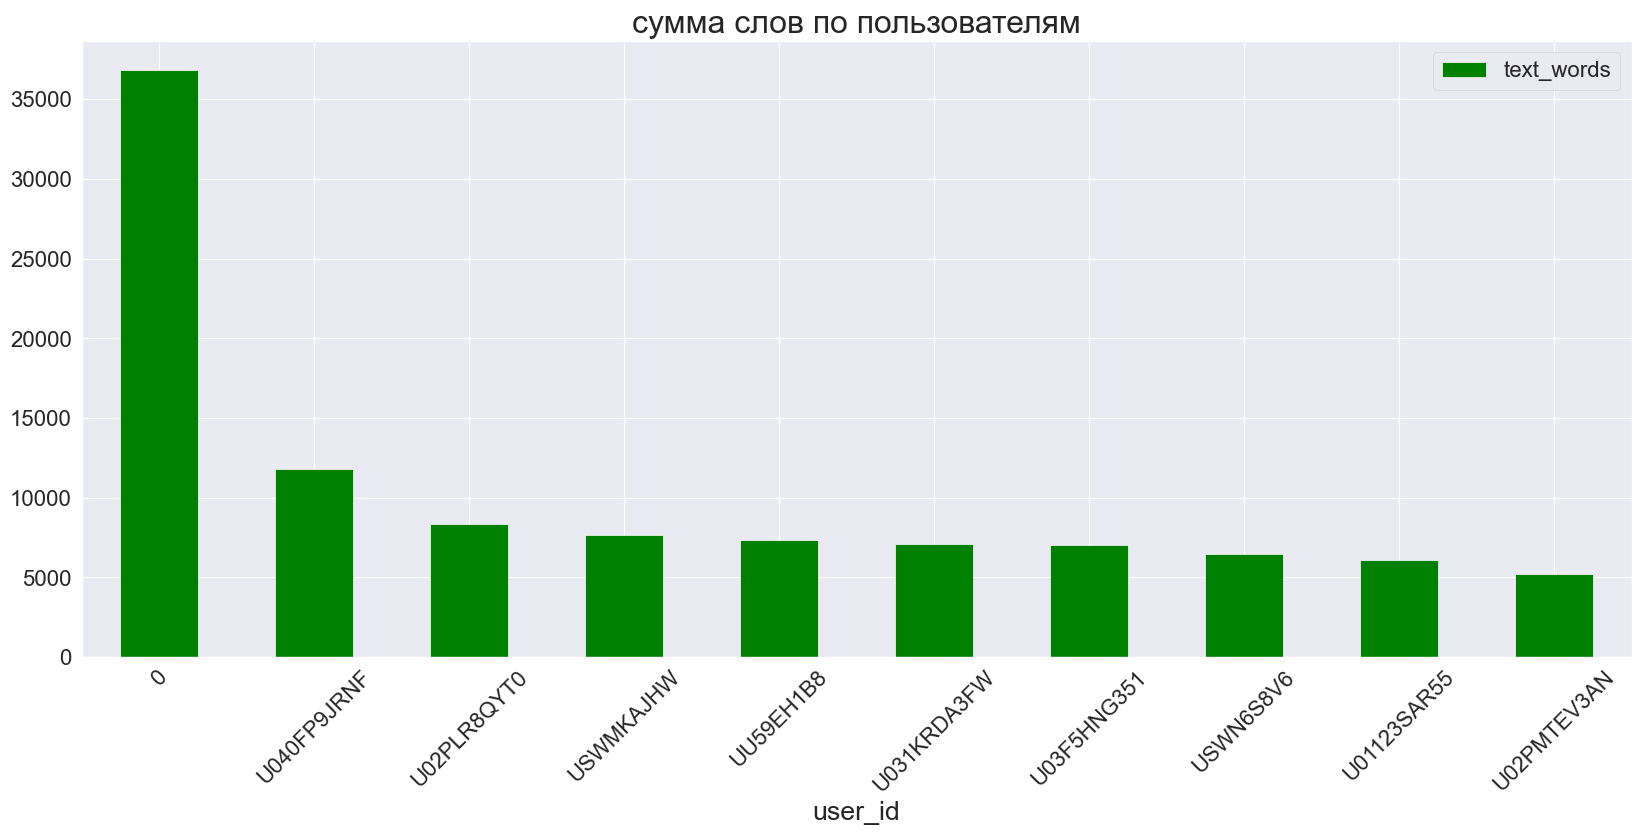

In [78]:
top_user = df[['text_words','user_id']] \
    .groupby('user_id').agg('sum') \
    .sort_values(by='text_words', ascending=False)
top_user = top_user.head(10)
top_user.plot(title='сумма слов по пользователям', kind='bar',color = 'g')
plt.xticks(rotation = 45);

**Вывод:** Снова лидирует этот юзер 

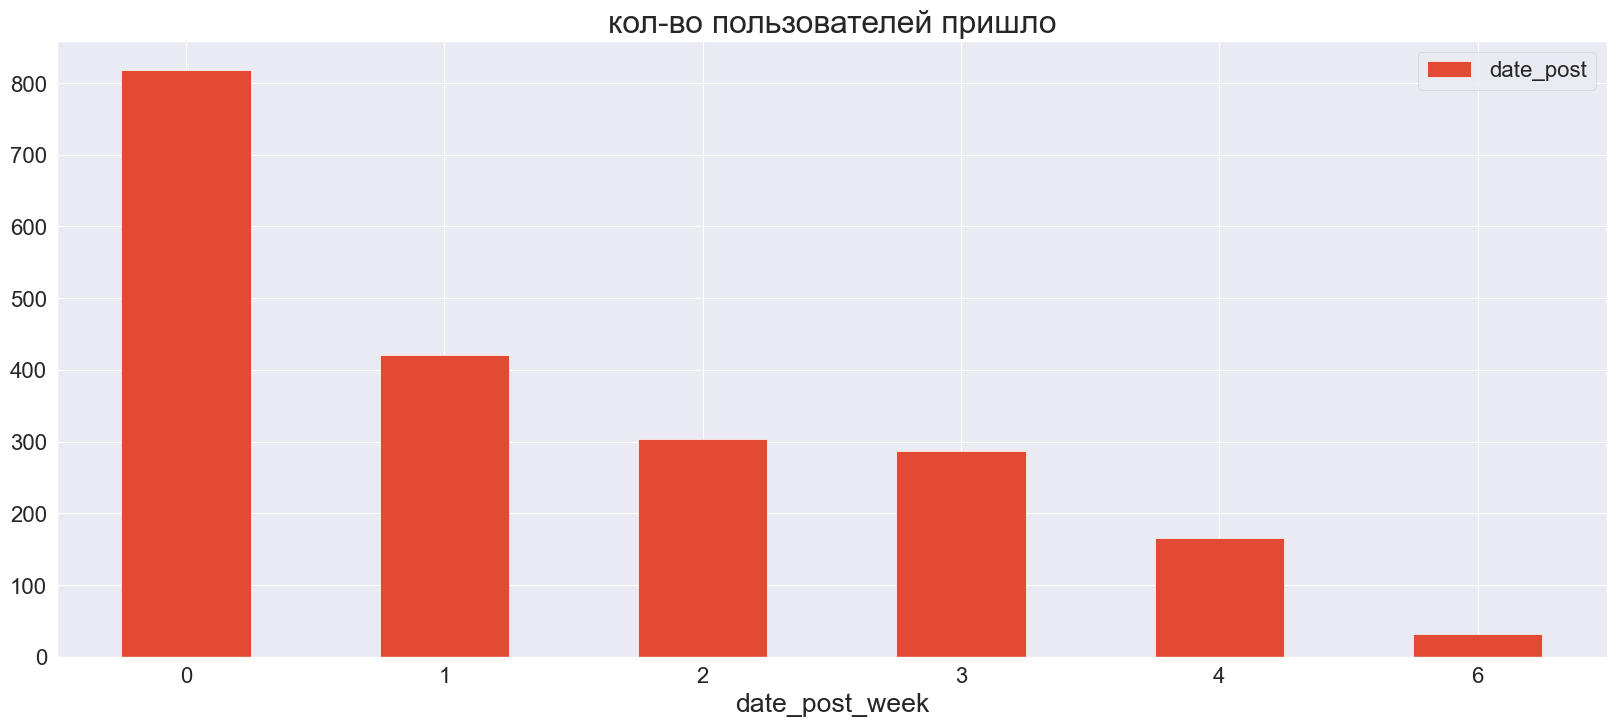

In [79]:
join = df.loc[df['subtype'] == 'channel_join']
df_j = join.groupby('date_post_week').agg({'date_post': 'count'})
df_j.plot(title='кол-во пользователей пришло', kind='bar')
plt.xticks(rotation = 0);

**Вывод:** Больше всего пришло в понедельник следом идут вторник и среда. Что логично. Обычно курсы или спринты начинают с понедельника

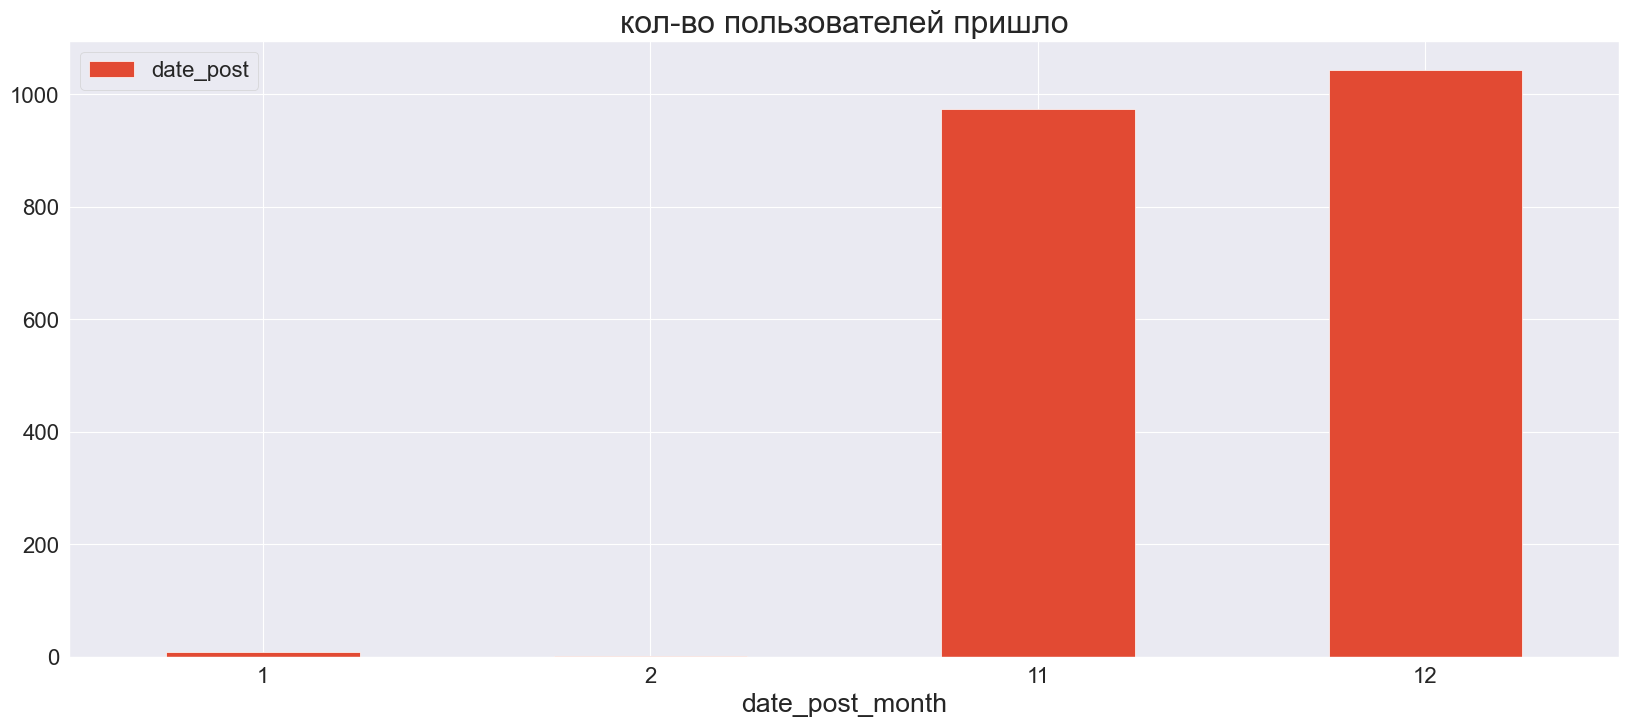

In [80]:
join2 = df.loc[df['subtype'] == 'channel_join']
df_jm = join2.groupby('date_post_month').agg({'date_post': 'count'})
df_jm.plot(title='кол-во пользователей пришло', kind='bar')
plt.xticks(rotation = 0);

**Вывод:** Мы рассматриваем всего два месяца, здесь трудно что-то предсказать.

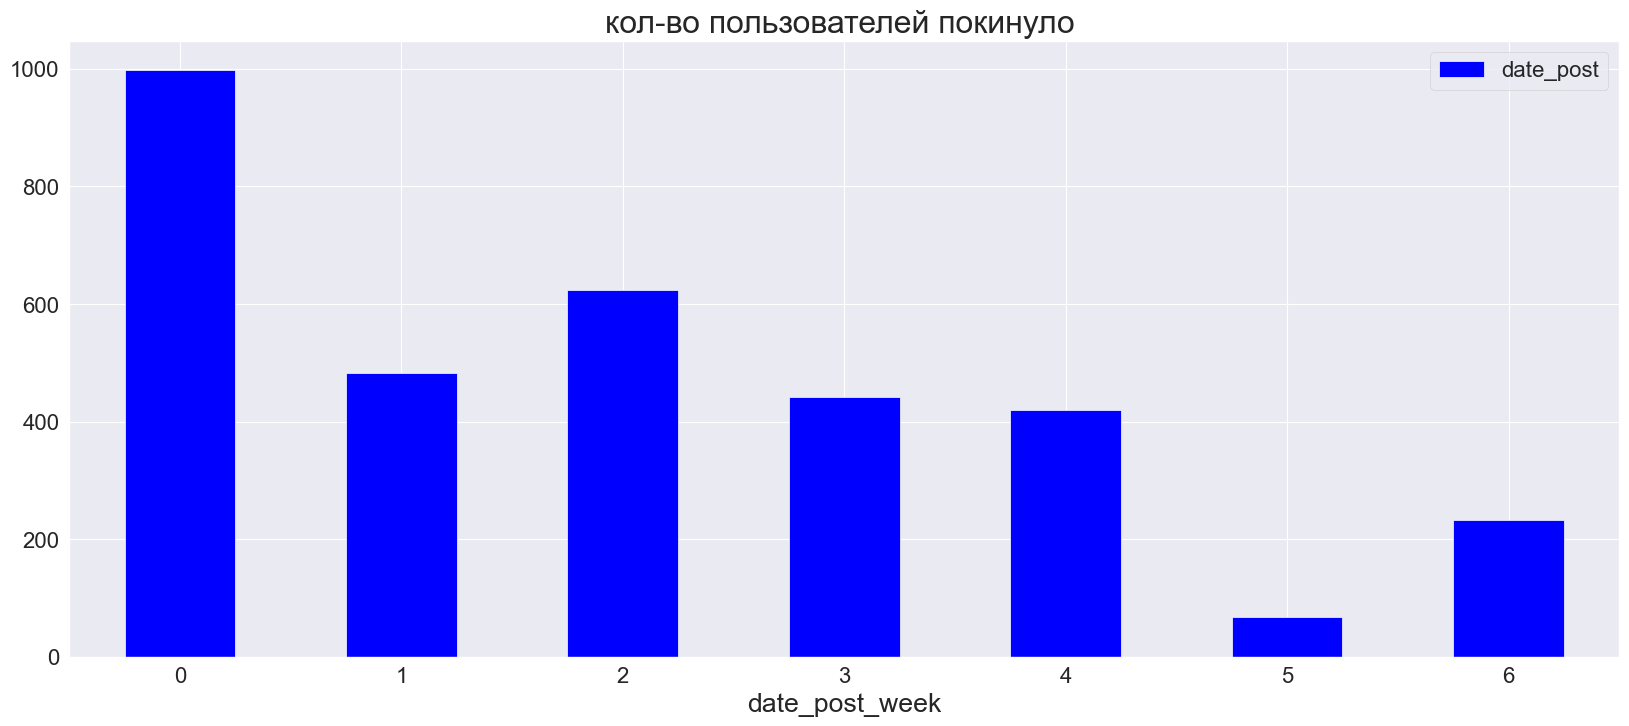

In [81]:
df_leave = df.loc[df['subtype'] == 'channel_leave']
df_l = df_leave.groupby('date_post_week').agg({'date_post': 'count'})
df_l.plot(title='кол-во пользователей покинуло ', kind='bar', color = 'b')
plt.xticks(rotation = 0);

**Вывод:** Как и с приходом больше всего уходов в понедельник, следом идут среда.

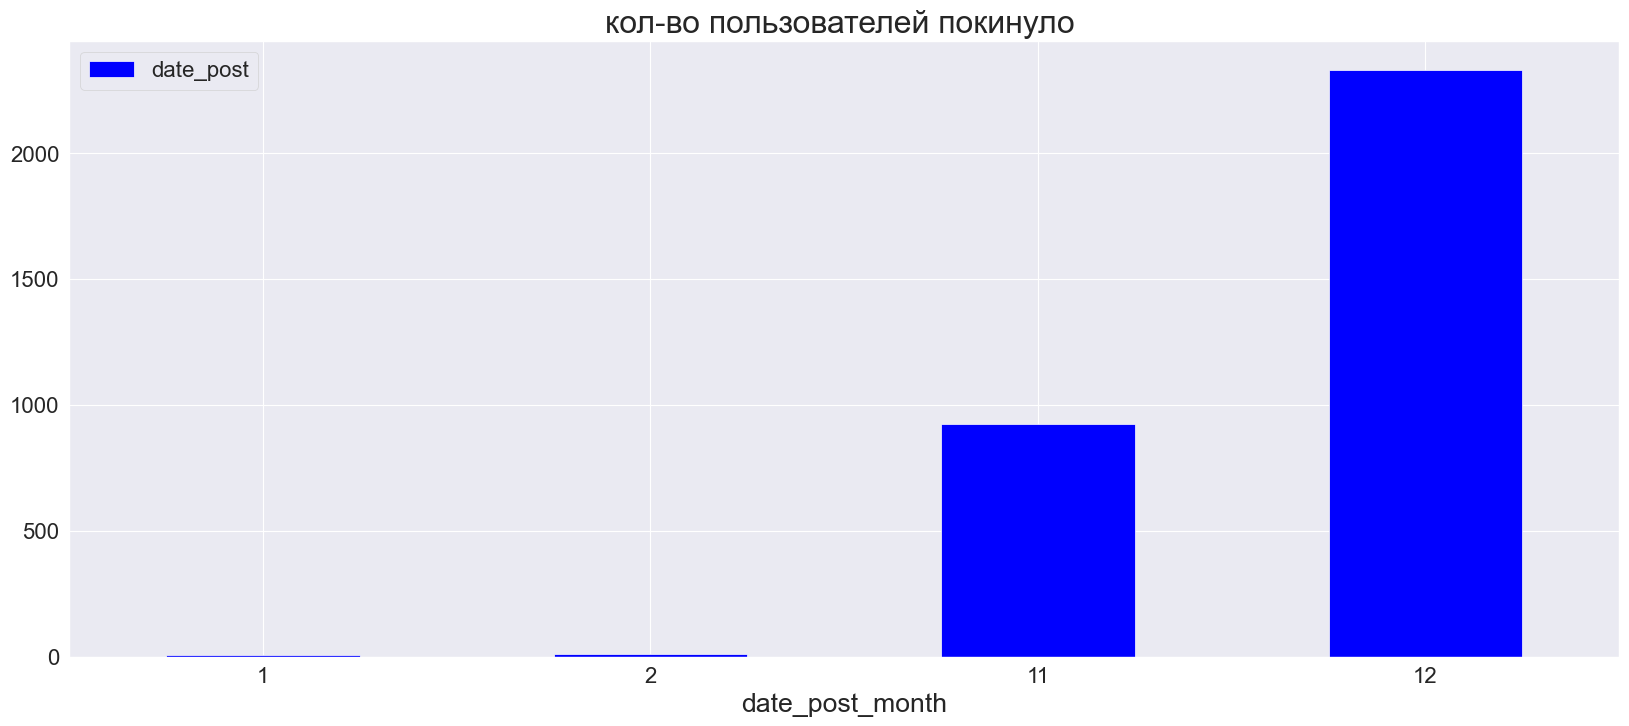

In [82]:
df_leave = df.loc[df['subtype'] == 'channel_leave']
df_l2 = df_leave.groupby('date_post_month').agg({'date_post': 'count'})
df_l2.plot(title='кол-во пользователей покинуло ', kind='bar',color = 'b')
plt.xticks(rotation = 0);

**Вывод:** Больше всего покидают в декабре.

# Общие выводы

**Предобработка данных:**
- На этапах предобработки были выявлены пропуски. Причиной появления пропусков может быть техническая ошибка.

- Были созданы дополнительные столбцы для построения графиков для дальнейшего анализа особенностей и зависимостей.

**Исследование данных и зависимостей:**

- Были построены графики для понимания взаимосвязей.

- Факторы влияния на отток пользователей: Факторы могут быть различные: не получение обратной связи на пост, невозможность оставлять комментарии, отсутствие мотивации, нарушение правил и т.д.

- Построив графики была выявлена закономерность:

- Пользователи смотрят каналы с утра, в начале недели.
- Покидают каналы так же с утра, в начале недели.
- Отток пользователей больше притока.
- В основном действия совершаются в один и тот же промежуток времени. Данной динамикой можно воспользоваться для удержания пользователей.
- Основная масса "публикуемых" пользователей не получает большого количества реакций.
Мало используются при написании сообщений вложений. Отсутствие визуального сопровождения постов пагубно влияет на понимание сути и может пагубно влиять на количество реакций.
- Большой текст в сообщениях плохо воспринимается пользователями.


Изучив данные мы можем сказать что лучше всего **публиковать посты в 7 и 14 часов, по понедельникам и вторникам**.

Тогда мы сможем получить как можно больше реакций на необходимую новость. Следует обратить внимание на группы в которых общение сведено к минимуму, вероятнее всего, как и в нашей группе студенты перешли в более удобный для них мессенджер в котором к сожалению не ведется статистика.

- По каналам общения projects и exercise являются самыми полными, есть смысл пересмотреть количество каналов для группы.

- Пользователи чаще заходят в канал в начале недели, но по понедельникам очень часто покидают канал.

- Значительная часть пользователей покинуло каналы на второй месяц данных, вероятно это академы и отчисления.

- Так же следует обратить внимание на сложность программы если слишком простая, то у студентов не возникнет вопросов в первые месяцы обучения, если слишком сложная то вопросов будет слишком много. И обратить внимание на активность куратора, если куратор пассивно общается со студентами и не интересуется их процессом обучения, то и отклик будет слабым.

**Рекомендации:**

- Выполнять действия ориентированные на привлечение и удержание пользователей.
- Обратить внимание на периоды публикации важных и интересных сообщений.